<p style="font-size:36px;text-align:center"> <b> Cancer Mutation diagnosis</b> </p>

In [135]:
!pip install imbalanced-learn mlxtend

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>Reading Data</h2>

<h3>Reading Gene and Variation Data</h3>

In [136]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [137]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>Preprocessing of text</h3>

In [138]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [139]:
#text processing stage.
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 28.13001847267151 seconds


In [140]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [141]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [142]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [143]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>Test, Train and Cross Validation Split</h3>

<h4>Splitting data into train, test and cross validation (64:20:16)</h4>

In [144]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [145]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

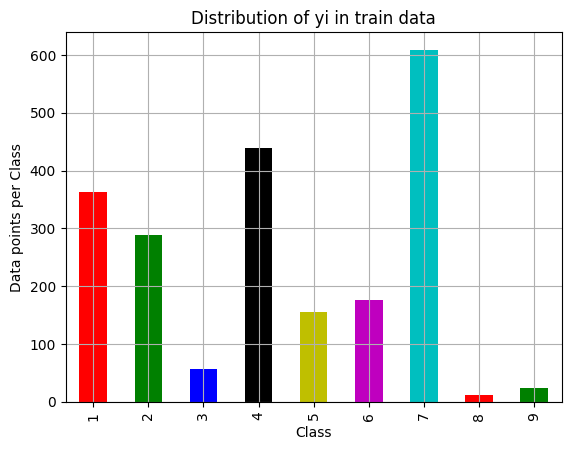

Number of data points in class 7: 609 (28.672%)
Number of data points in class 4: 439 (20.669%)
Number of data points in class 1: 363 (17.09%)
Number of data points in class 2: 289 (13.606%)
Number of data points in class 6: 176 (8.286%)
Number of data points in class 5: 155 (7.298%)
Number of data points in class 3: 57 (2.684%)
Number of data points in class 9: 24 (1.13%)
Number of data points in class 8: 12 (0.565%)
--------------------------------------------------------------------------------


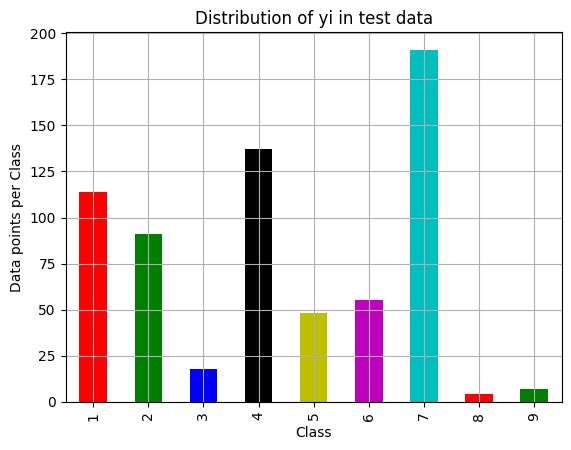

Number of data points in class 7: 191 (28.722%)
Number of data points in class 4: 137 (20.602%)
Number of data points in class 1: 114 (17.143%)
Number of data points in class 2: 91 (13.684%)
Number of data points in class 6: 55 (8.271%)
Number of data points in class 5: 48 (7.218%)
Number of data points in class 3: 18 (2.707%)
Number of data points in class 9: 7 (1.053%)
Number of data points in class 8: 4 (0.602%)
--------------------------------------------------------------------------------


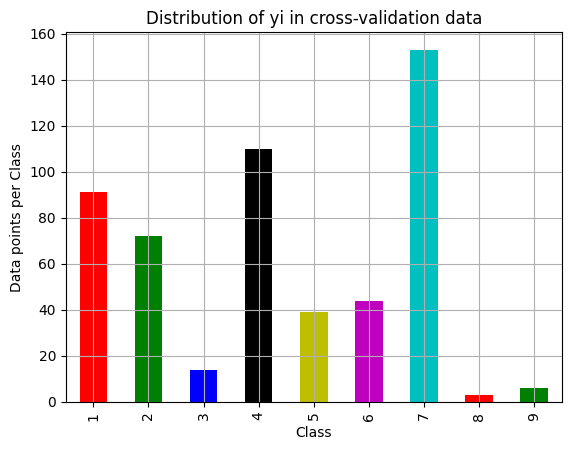

Number of data points in class 7: 153 (28.759%)
Number of data points in class 4: 110 (20.677%)
Number of data points in class 1: 91 (17.105%)
Number of data points in class 2: 72 (13.534%)
Number of data points in class 6: 44 (8.271%)
Number of data points in class 5: 39 (7.331%)
Number of data points in class 3: 14 (2.632%)
Number of data points in class 9: 6 (1.128%)
Number of data points in class 8: 3 (0.564%)


In [146]:

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


# Sort and display class distribution in descending order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1}: {train_class_distribution.values[i]} ({np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3)}%)')

print('-' * 80)

test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1}: {test_class_distribution.values[i]} ({np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3)}%)')

print('-' * 80)

cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross-validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1}: {cv_class_distribution.values[i]} ({np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3)}%)')



<h2> Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [147]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]

    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model: 2.5496800801321298
Log loss on Test Data using Random Model: 2.555765369003078
-------------------- Confusion matrix --------------------


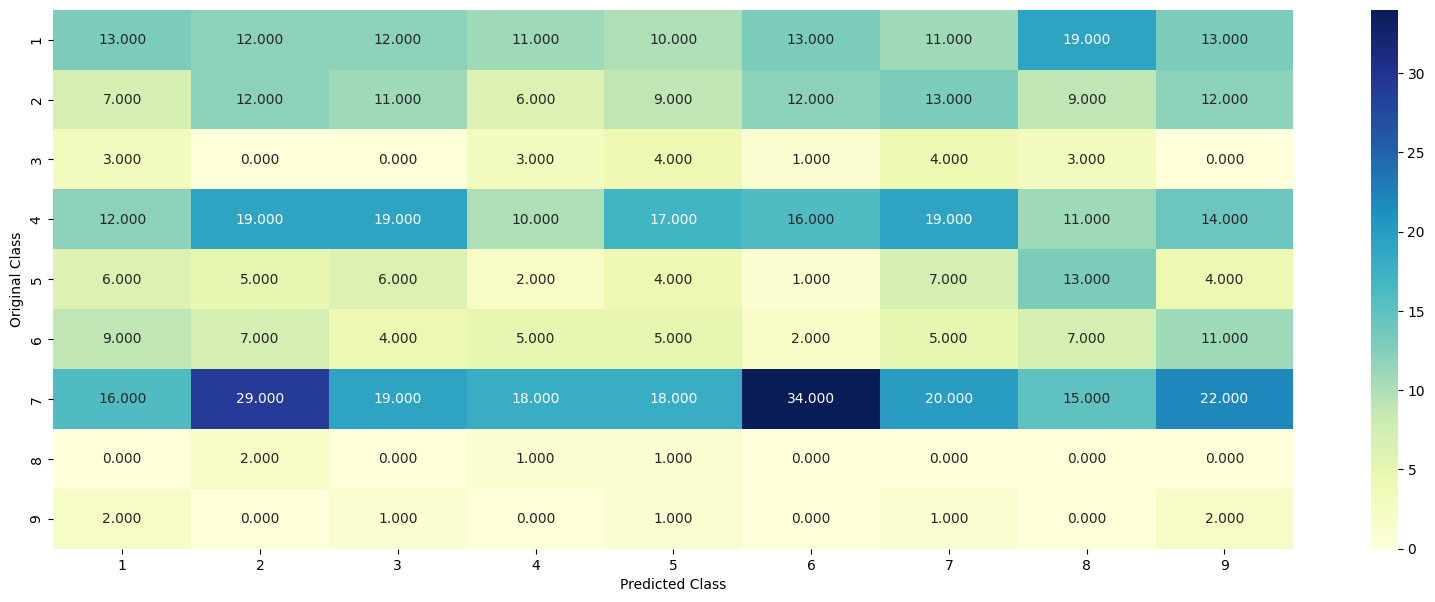

-------------------- Precision matrix (Columm Sum=1) --------------------


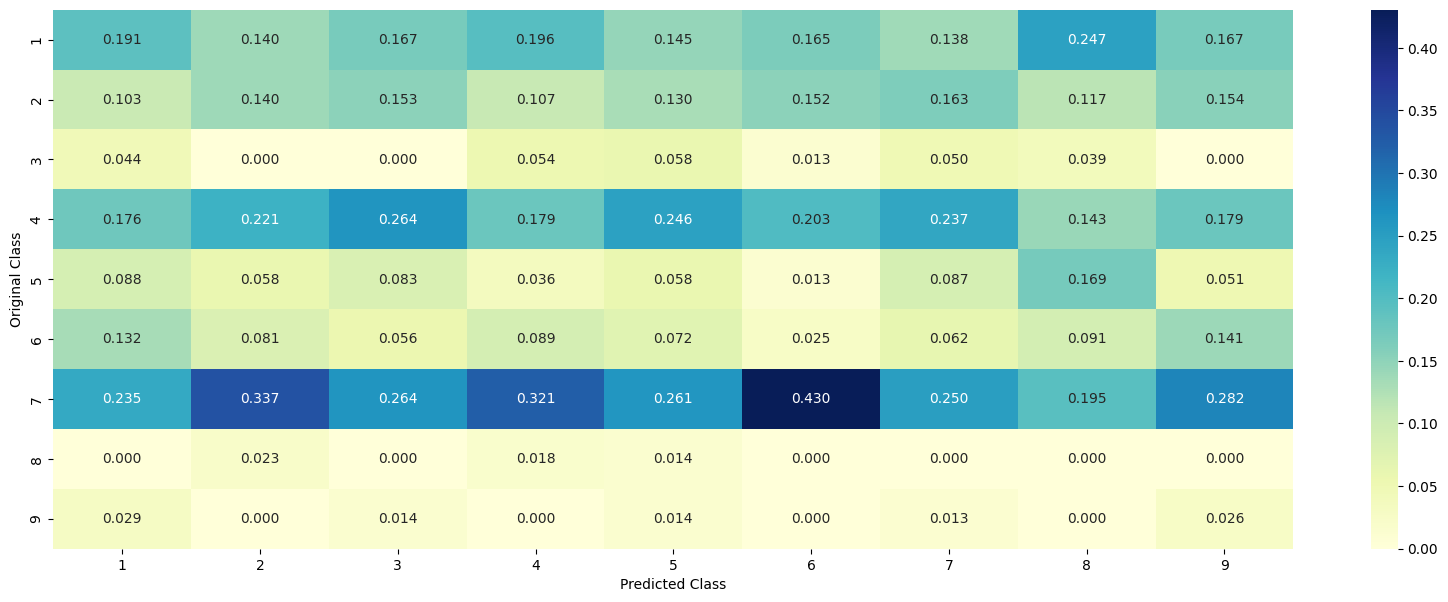

-------------------- Recall matrix (Row sum=1) --------------------


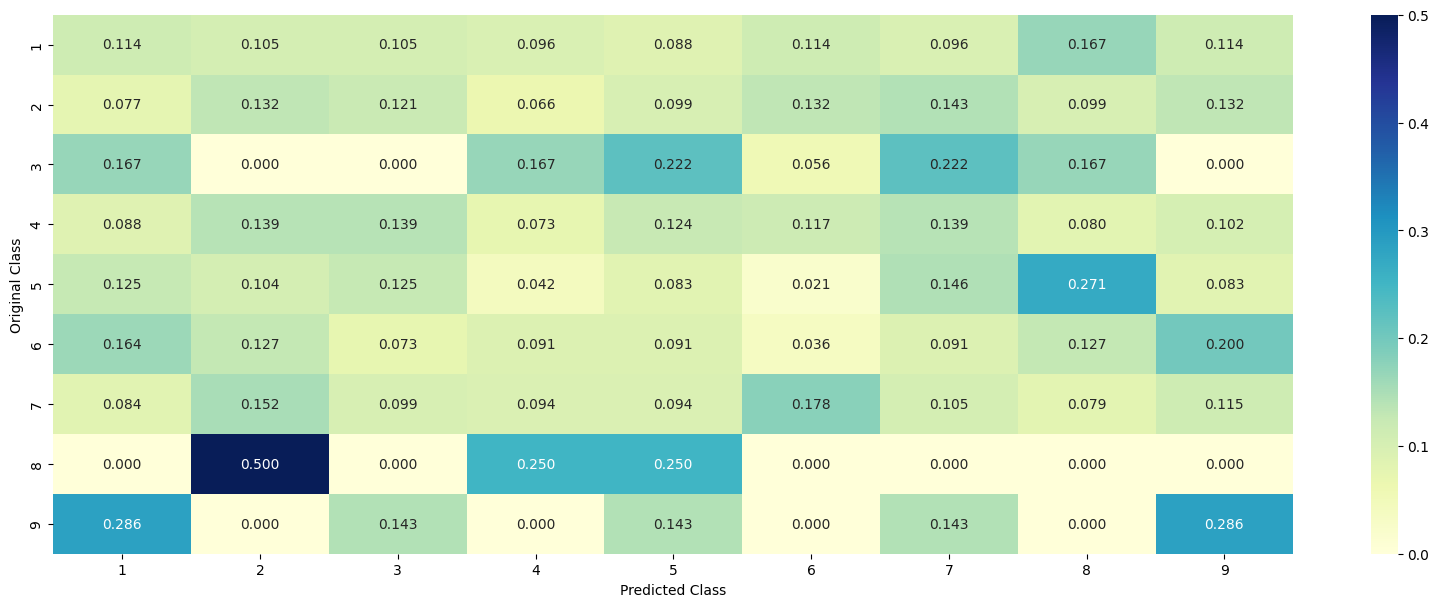

In [148]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = ((rand_probs / np.sum(rand_probs))[0])

print("Log loss on Cross Validation Data using Random Model:",
      log_loss(y_cv - 1, cv_predicted_y, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8]))


# Test-Set error.
# we create a output array that has exactly same size as the test data
test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = ((rand_probs / np.sum(rand_probs))[0])

print("Log loss on Test Data using Random Model:",
      log_loss(y_test - 1, test_predicted_y, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8]))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y + 1)


<h2> Univariate Analysis</h2>

In [149]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()

    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()

    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class
            # 2470  2470  BRCA1                S1715C      1
            # 2486  2486  BRCA1                S1841R      1
            # 2614  2614  BRCA1                   M1R      1
            # 2432  2432  BRCA1                L1657P      1
            # 2567  2567  BRCA1                T1685A      1
            # 2583  2583  BRCA1                E1660G      1
            # 2634  2634  BRCA1                W1718L      1
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]

            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788],
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837],
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816],
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608],
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289],
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912],
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()

    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3> Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [150]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
Gene
BRCA1     181
TP53      104
EGFR       93
PTEN       86
BRCA2      72
KIT        67
BRAF       51
ERBB2      47
ALK        40
PDGFRA     40
Name: count, dtype: int64


In [151]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 236 different categories of genes in the train data, and they are distibuted as follows


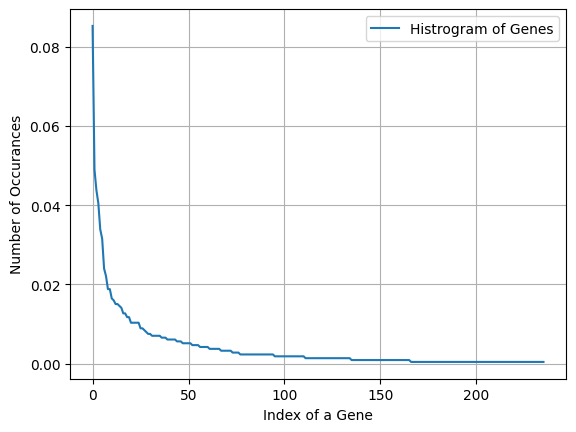

In [152]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


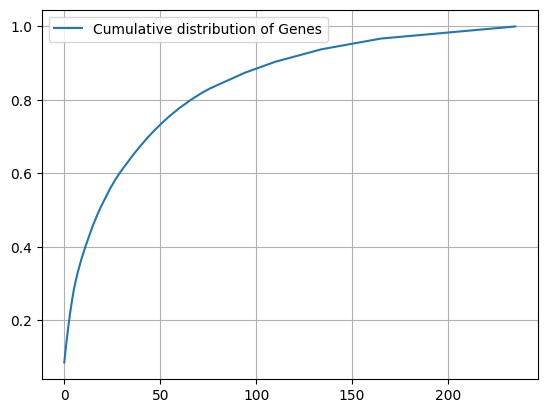

In [153]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable

<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [154]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [155]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [156]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [157]:
train_df['Gene'].head()

,Gene
2711,BRAF
2584,BRCA1
2866,BRCA2
3287,RET
1522,ALK


In [158]:
gene_vectorizer.get_feature_names_out()


array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'arid5b', 'asxl1', 'asxl2', 'atm',
       'atr', 'atrx', 'aurka', 'axin1', 'b2m', 'bap1', 'bcl10', 'bcl2',
       'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4', 'brip1',
       'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd2',
       'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdkn1a',
       'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp',
       'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'egfr',
       'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fancc', 'fat1', 'fbxw7',
       'fgf3', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt1', 'flt3',
       'foxa1', 'foxl2', 'foxo1', 'foxp1', 'gata3', 'gna11', 'gnas',
       'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1', 'idh2',
       'igf1r', 'ik

In [159]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 235)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For alpha = 1e-05 Log loss: 1.2035959142040291
For alpha = 0.0001 Log loss: 1.1694043223706585
For alpha = 0.001 Log loss: 1.2098637368323113
For alpha = 0.01 Log loss: 1.3224418152232063
For alpha = 0.1 Log loss: 1.4215475491492453
For alpha = 1 Log loss: 1.4648848142889015


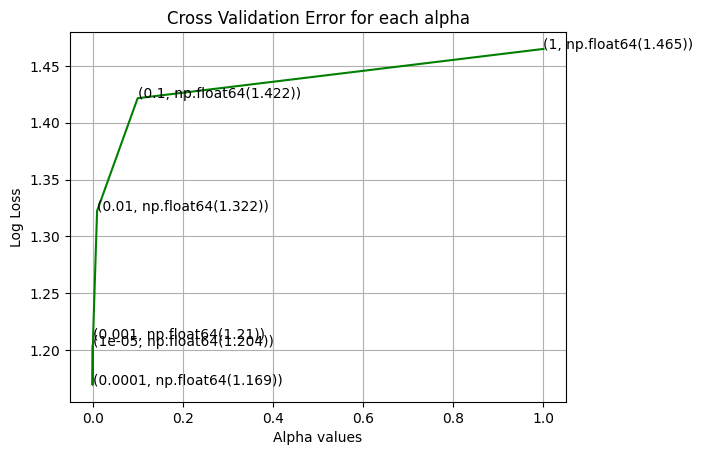

Best alpha = 0.0001 Train log loss: 0.9809396845697433
Best alpha = 0.0001 CV log loss: 1.1694043223706585
Best alpha = 0.0001 Test log loss: 1.2282320426728672


In [160]:
alpha = [10 ** x for x in range(-5, 1)]  # hyperparam for SGD classifier.

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))

    print('For alpha =', i, "Log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

# Plotting log loss vs alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.show()

# Get best alpha
best_alpha = np.argmin(cv_log_error_array)

# Re-train with best alpha
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

# Train log loss
predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "Train log loss:", log_loss(y_train, predict_y, labels=clf.classes_))

# CV log loss
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "CV log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

# Test log loss
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "Test log loss:", log_loss(y_test, predict_y, labels=clf.classes_))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [161]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 518 out of  532 : 97.36842105263158


<h3>Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [162]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1924
Variation
Truncating Mutations    59
Deletion                50
Amplification           44
Fusions                 25
Overexpression           5
Q61H                     3
Q61L                     3
S308A                    2
G13C                     2
V321M                    2
Name: count, dtype: int64


In [163]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1924 different categories of variations in the train data, and they are distibuted as follows


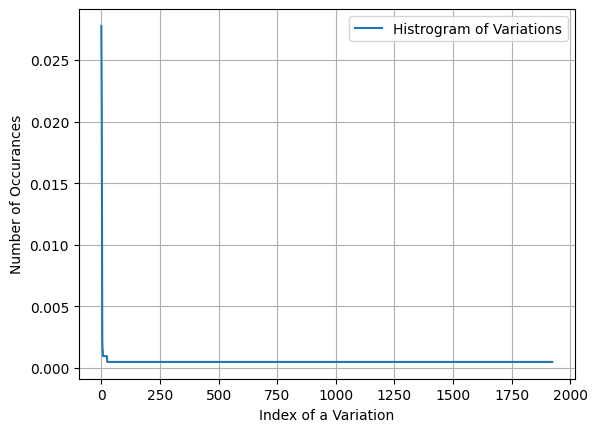

In [164]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.05131827 0.0720339  ... 0.99905838 0.99952919 1.        ]


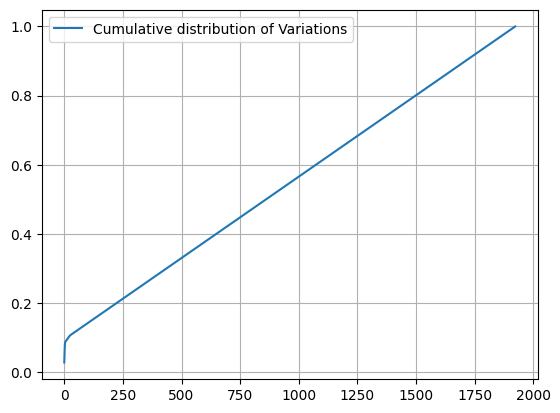

In [165]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [166]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [167]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [168]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [169]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1959)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For alpha = 1e-05 Log loss: 1.691201340893669
For alpha = 0.0001 Log loss: 1.6862344391322799
For alpha = 0.001 Log loss: 1.6936084915852359
For alpha = 0.01 Log loss: 1.7078758394686293
For alpha = 0.1 Log loss: 1.7301298116032156
For alpha = 1 Log loss: 1.7310811445233214


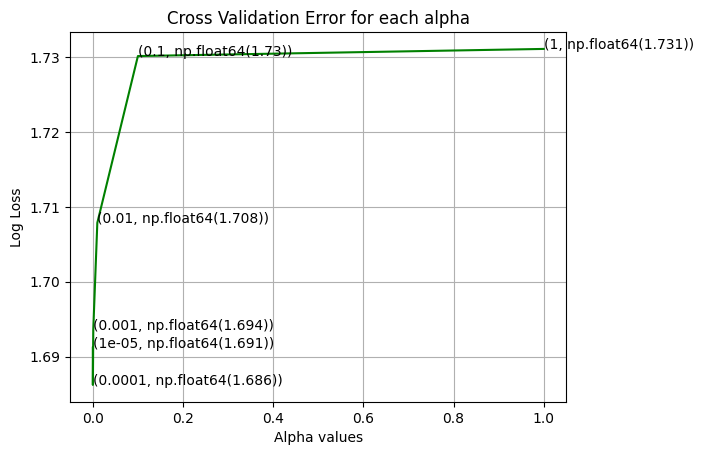

Best alpha = 0.0001 Train log loss: 0.7496376829298659
Best alpha = 0.0001 CV log loss: 1.6862344391322799
Best alpha = 0.0001 Test log loss: 1.7031131899182637


In [170]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For alpha =', i, "Log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "Train log loss:", log_loss(y_train, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "CV log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('Best alpha =', alpha[best_alpha], "Test log loss:", log_loss(y_test, predict_y, labels=clf.classes_))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [171]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1924  genes in test and cross validation data sets?
Ans
1. In test data 69 out of 665 : 10.37593984962406
2. In cross validation data 52 out of  532 : 9.774436090225564


<h3> Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [172]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [173]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [174]:
# building a CountVectorizer with all the words that occurred minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names_out()

# Summing occurrences of each word across all documents
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# Mapping each word to its frequency
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))


Total number of unique words in train data: 52820


In [175]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [176]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [177]:

# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [178]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [179]:

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [180]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.int64(3): 5481, np.int64(4): 3210, np.int64(5): 2901, np.int64(6): 2491, np.int64(7): 2169, np.int64(8): 2098, np.int64(10): 1730, np.int64(9): 1538, np.int64(12): 1327, np.int64(14): 1077, np.int64(11): 1028, np.int64(16): 1016, np.int64(13): 964, np.int64(15): 737, np.int64(18): 674, np.int64(17): 591, np.int64(20): 583, np.int64(24): 575, np.int64(21): 505, np.int64(25): 475, np.int64(19): 458, np.int64(23): 411, np.int64(22): 395, np.int64(26): 378, np.int64(34): 367, np.int64(28): 367, np.int64(27): 350, np.int64(30): 346, np.int64(36): 344, np.int64(32): 302, np.int64(33): 271, np.int64(54): 266, np.int64(29): 264, np.int64(31): 254, np.int64(40): 234, np.int64(35): 225, np.int64(50): 215, np.int64(39): 213, np.int64(37): 209, np.int64(42): 201, np.int64(48): 196, np.int64(38): 190, np.int64(41): 183, np.int64(44): 175, np.int64(45): 160, np.int64(56): 157, np.int64(46): 157, np.int64(55): 152, np.int64(52): 151, np.int64(43): 149, np.int64(57): 136, np.int64(51): 135

For values of alpha = 1e-05 The log loss is: 1.2979865764361707
For values of alpha = 0.0001 The log loss is: 1.1702168751464537
For values of alpha = 0.001 The log loss is: 1.1697694850998261
For values of alpha = 0.01 The log loss is: 1.2591059653095489
For values of alpha = 0.1 The log loss is: 1.475677446743491
For values of alpha = 1 The log loss is: 1.6692977766062511


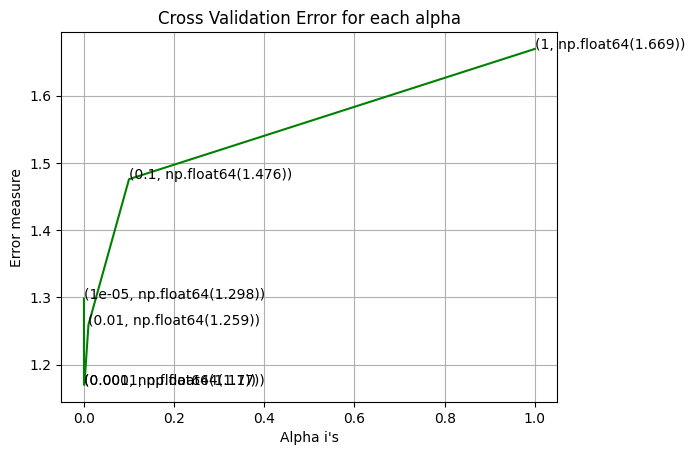

Train log loss: 0.6572335535547108
Cross-validation log loss: 1.1697694850998261
Test log loss: 1.1681897595631319


In [181]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))

    print('For values of alpha =', i, "The log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('Train log loss:', log_loss(y_train, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('Cross-validation log loss:', log_loss(y_cv, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('Test log loss:', log_loss(y_test, predict_y, labels=clf.classes_))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [182]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features), df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1, len2


In [183]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.563 % of word of test data appeared in train data
97.879 % of word of Cross Validation appeared in train data


<h1> Machine Learning Models</h1>

In [184]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [185]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs)


In [186]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature is present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_vec.get_feature_names_out())

    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, f"Gene feature [{word}] present in test data point [{yes_no}]")
        elif v < fea1_len + fea2_len:
            word = var_vec.get_feature_names_out()[v - fea1_len]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, f"Variation feature [{word}] present in test data point [{yes_no}]")
        else:
            word = text_vec.get_feature_names_out()[v - (fea1_len + fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, f"Text feature [{word}] present in test data point [{yes_no}]")

    print(f"Out of the top {no_features} features, {word_present} are present in the query point")


<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [187]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2],
#      [3, 4]]
# b = [[4, 5],
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [188]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55014)
(number of data points * number of features) in test data =  (665, 55014)
(number of data points * number of features) in cross validation data = (532, 55014)


In [189]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>Base Line Model</h2>

<h3>Naive Bayes</h3>

<h4> Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2539694773193357
for alpha = 0.0001
Log Loss : 1.2512613715561778
for alpha = 0.001
Log Loss : 1.2434880343517805
for alpha = 0.1
Log Loss : 1.2392134968026756
for alpha = 1
Log Loss : 1.235544613096643
for alpha = 10
Log Loss : 1.3559223131739149
for alpha = 100
Log Loss : 1.345573665111444
for alpha = 1000
Log Loss : 1.2819240313022777


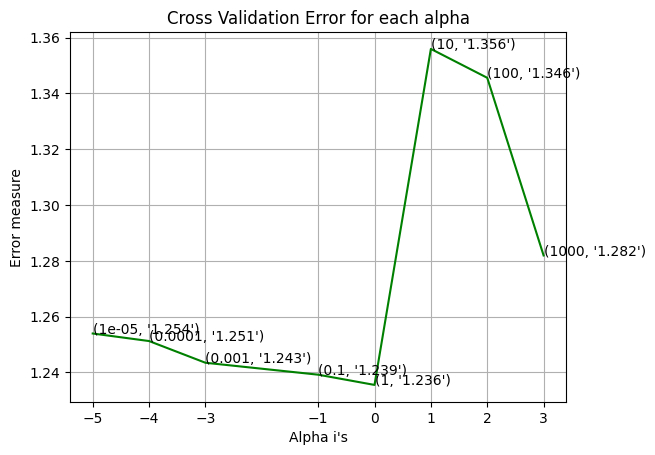

For values of best alpha = 1 The train log loss is: 0.8921447538685343
For values of best alpha = 1 The cross validation log loss is: 1.235544613096643
For values of best alpha = 1 The test log loss is: 1.2670781335597738


In [190]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))

    print("Log Loss :", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],
      "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],
      "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],
      "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))


<h4>Testing the model with best hyper paramters</h4>

Log Loss : 1.235544613096643
Number of missclassified point : 0.36278195488721804
-------------------- Confusion matrix --------------------


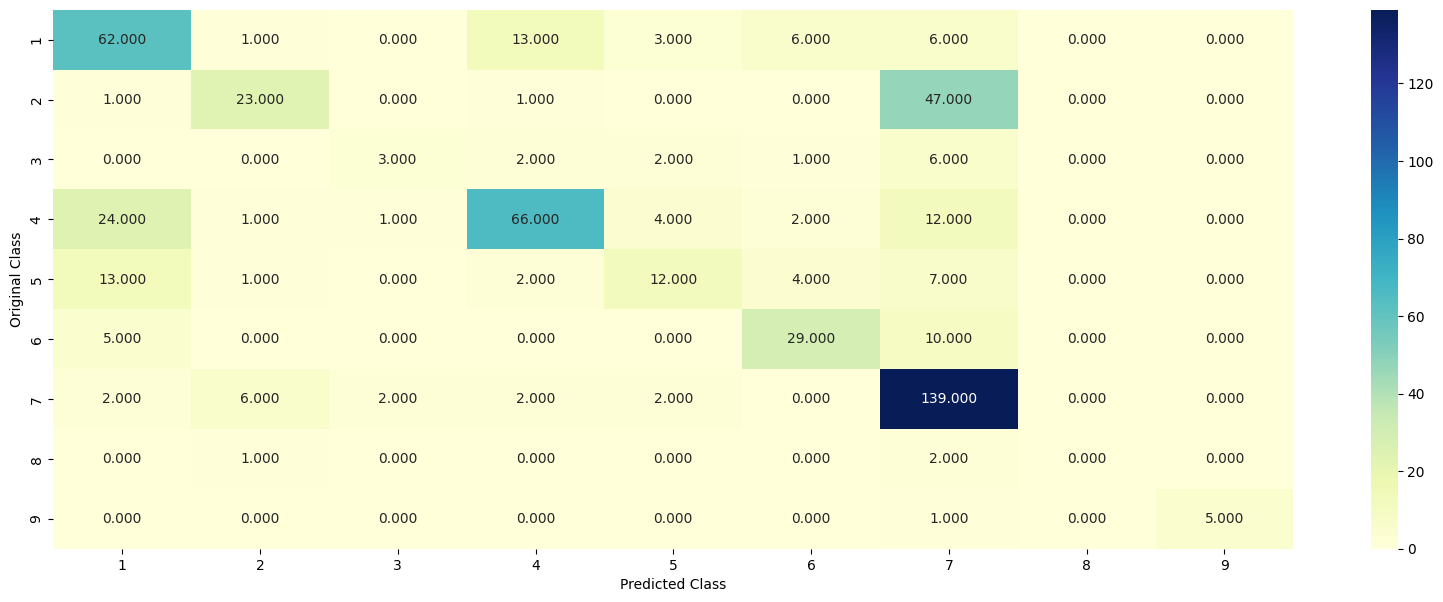

-------------------- Precision matrix (Columm Sum=1) --------------------


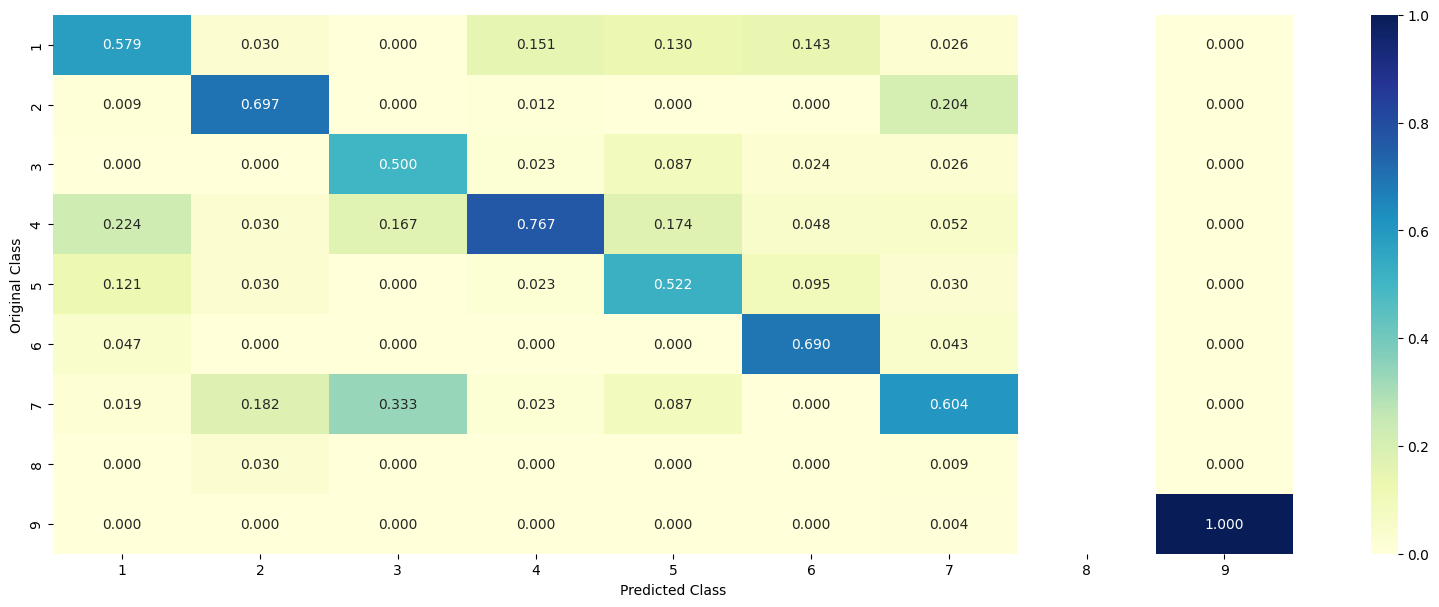

-------------------- Recall matrix (Row sum=1) --------------------


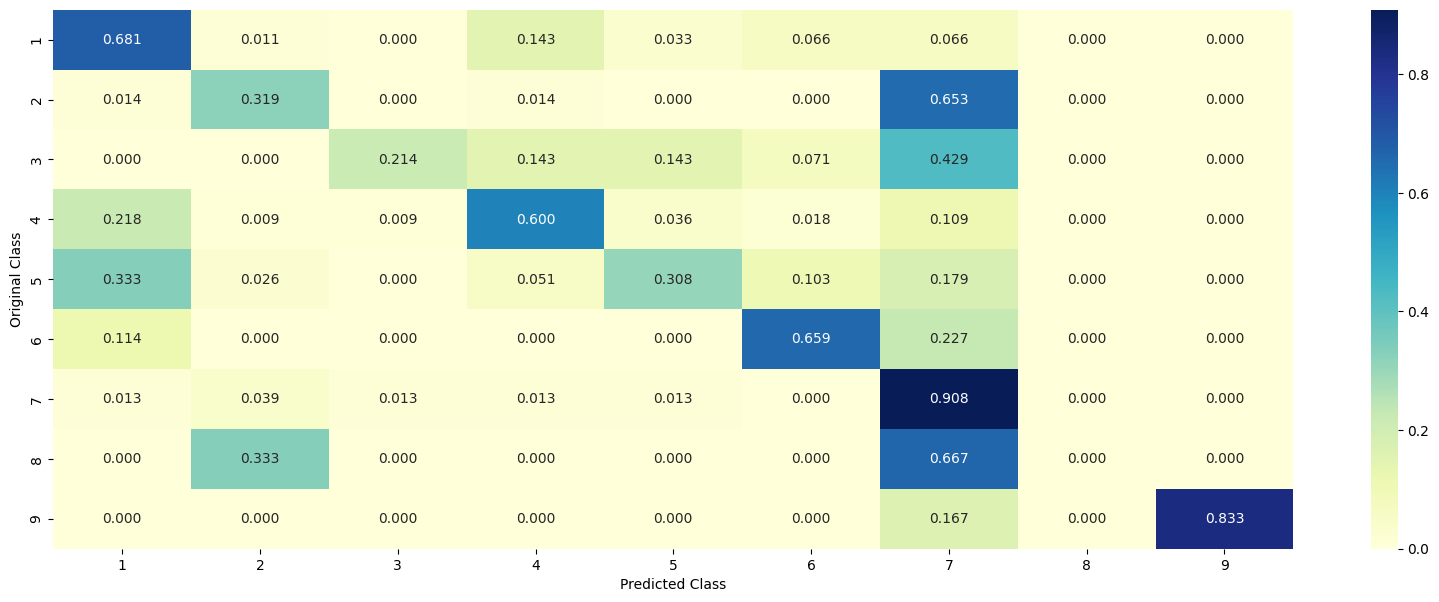

In [191]:

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>Feature Importance, Correctly classified point</h4>

In [192]:
test_point_index = 1
no_feature = 100

# Get the test point correctly
test_point = test_x_onehotCoding[test_point_index]

# Predict class
predicted_cls = sig_clf.predict(test_point)
print("Predicted Class:", predicted_cls[0])

# Predict probabilities
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_point), 4))
print("Actual Class:", test_y[test_point_index])

# Get class index from class label
class_label = predicted_cls[0]
class_index = list(clf.classes_).index(class_label)

# Use feature_log_prob_ instead of coef_
indices = np.argsort(-clf.feature_log_prob_[class_index])[:no_feature]

print("-" * 50)
get_impfeature_names(indices,
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index],
                     no_feature)


Predicted Class: 2
Predicted Class Probabilities: [[0.073  0.2929 0.0254 0.1203 0.0621 0.1676 0.2446 0.0083 0.0059]]
Actual Class: 5
--------------------------------------------------
16 Text feature [identified] present in test data point [True]
18 Text feature [detection] present in test data point [True]
19 Text feature [sequencing] present in test data point [True]
21 Text feature [clinical] present in test data point [True]
22 Text feature [new] present in test data point [True]
31 Text feature [identify] present in test data point [True]
32 Text feature [confirmed] present in test data point [True]
33 Text feature [different] present in test data point [True]
34 Text feature [using] present in test data point [True]
35 Text feature [gene] present in test data point [True]
37 Text feature [present] present in test data point [True]
38 Text feature [well] present in test data point [True]
39 Text feature [kinase] present in test data point [True]
42 Text feature [found] present in 

<h4> Feature Importance, Incorrectly classified point</h4>

In [193]:
test_point_index = 100
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class:", test_y[test_point_index])

# Get class index properly
class_index = int(predicted_cls[0]) - 1

# Sort features by their log-probability for the predicted class
indices = np.argsort(-clf.feature_log_prob_[class_index])[:no_feature]

print("-" * 50)
get_impfeature_names(indices,
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index],
                     no_feature)


Predicted Class: 7
Predicted Class Probabilities: [[0.0563 0.0971 0.0197 0.0941 0.0485 0.0433 0.6299 0.0065 0.0046]]
Actual Class: 2
--------------------------------------------------
20 Text feature [kinase] present in test data point [True]
21 Text feature [downstream] present in test data point [True]
23 Text feature [inhibitor] present in test data point [True]
26 Text feature [expressing] present in test data point [True]
28 Text feature [potential] present in test data point [True]
29 Text feature [independent] present in test data point [True]
30 Text feature [well] present in test data point [True]
32 Text feature [cell] present in test data point [True]
33 Text feature [recently] present in test data point [True]
34 Text feature [previously] present in test data point [True]
37 Text feature [cells] present in test data point [True]
41 Text feature [10] present in test data point [True]
42 Text feature [activation] present in test data point [True]
43 Text feature [growth] pres

<h2>K Nearest Neighbour Classification</h2>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0745205975205023
for alpha = 11
Log Loss : 1.0305026214024626
for alpha = 15
Log Loss : 1.031838740302884
for alpha = 21
Log Loss : 1.0486270264761435
for alpha = 31
Log Loss : 1.0733466655432509
for alpha = 41
Log Loss : 1.0602406521679697
for alpha = 51
Log Loss : 1.060872520762824
for alpha = 99
Log Loss : 1.076942219495108


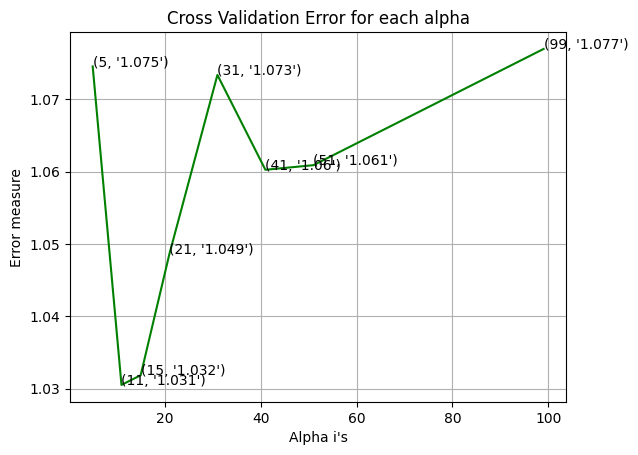

For values of best alpha =  11 The train log loss is: 0.605222853532161
For values of best alpha =  11 The cross validation log loss is: 1.0305026214024626
For values of best alpha =  11 The test log loss is: 1.1333046648767222


In [194]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.0305026214024626
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


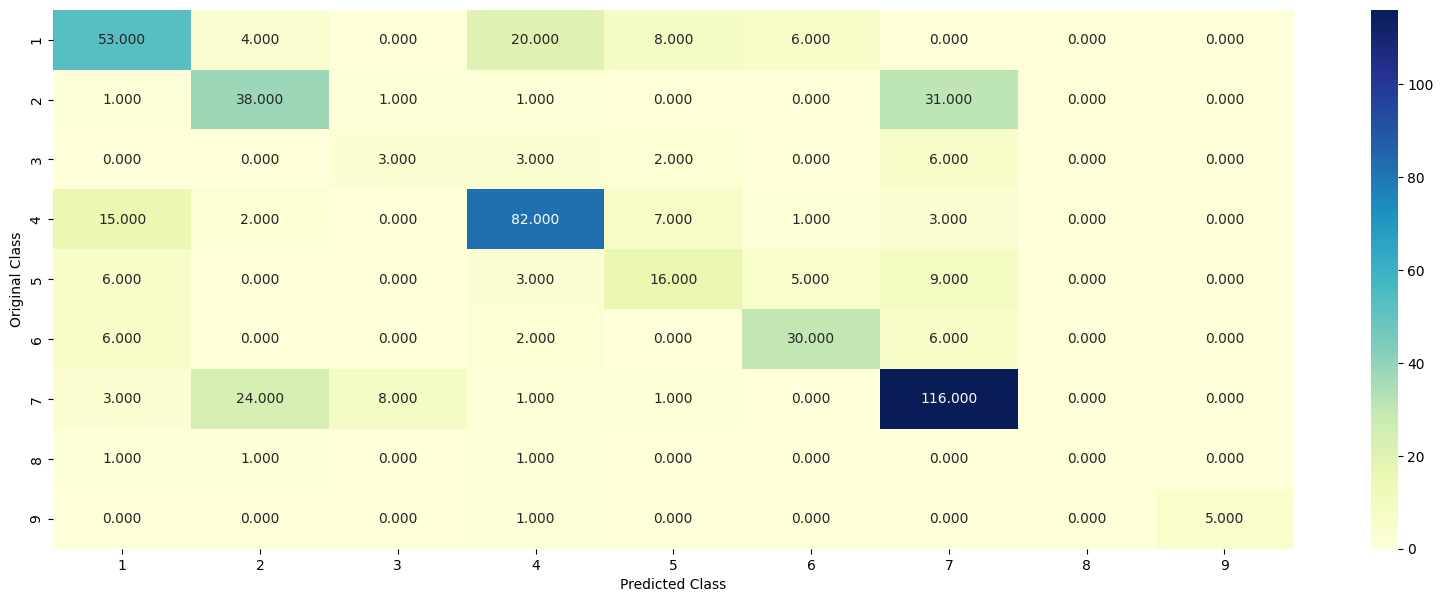

-------------------- Precision matrix (Columm Sum=1) --------------------


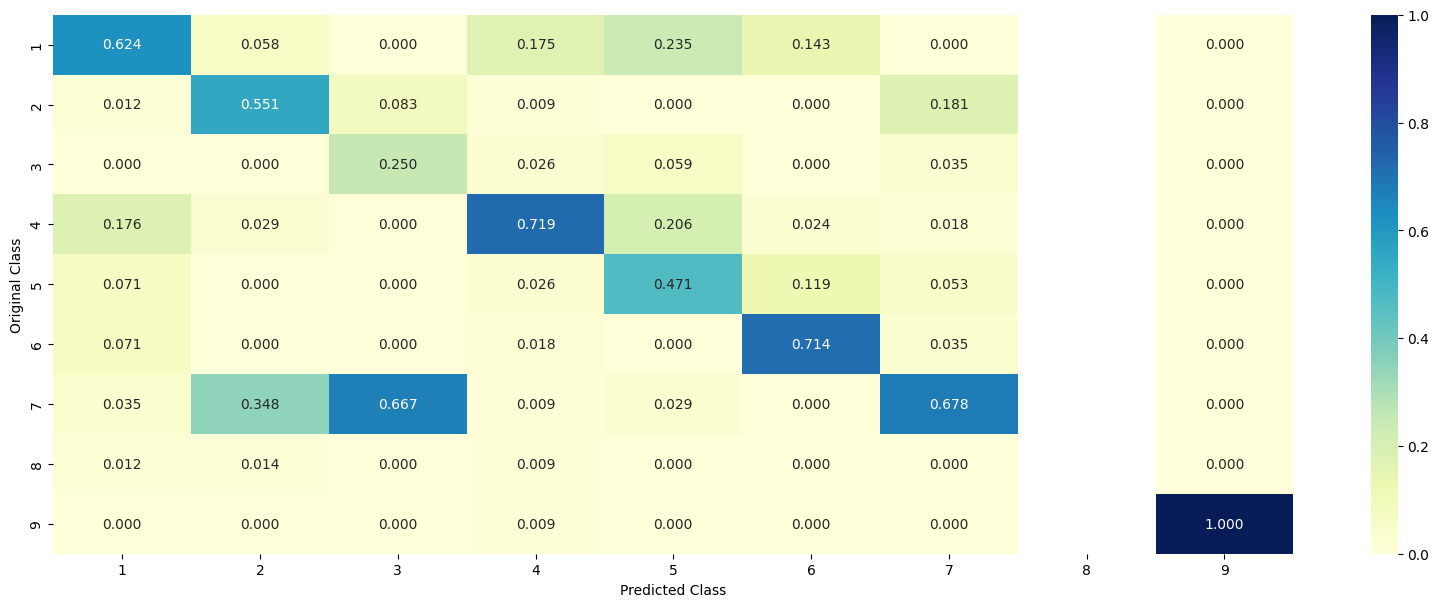

-------------------- Recall matrix (Row sum=1) --------------------


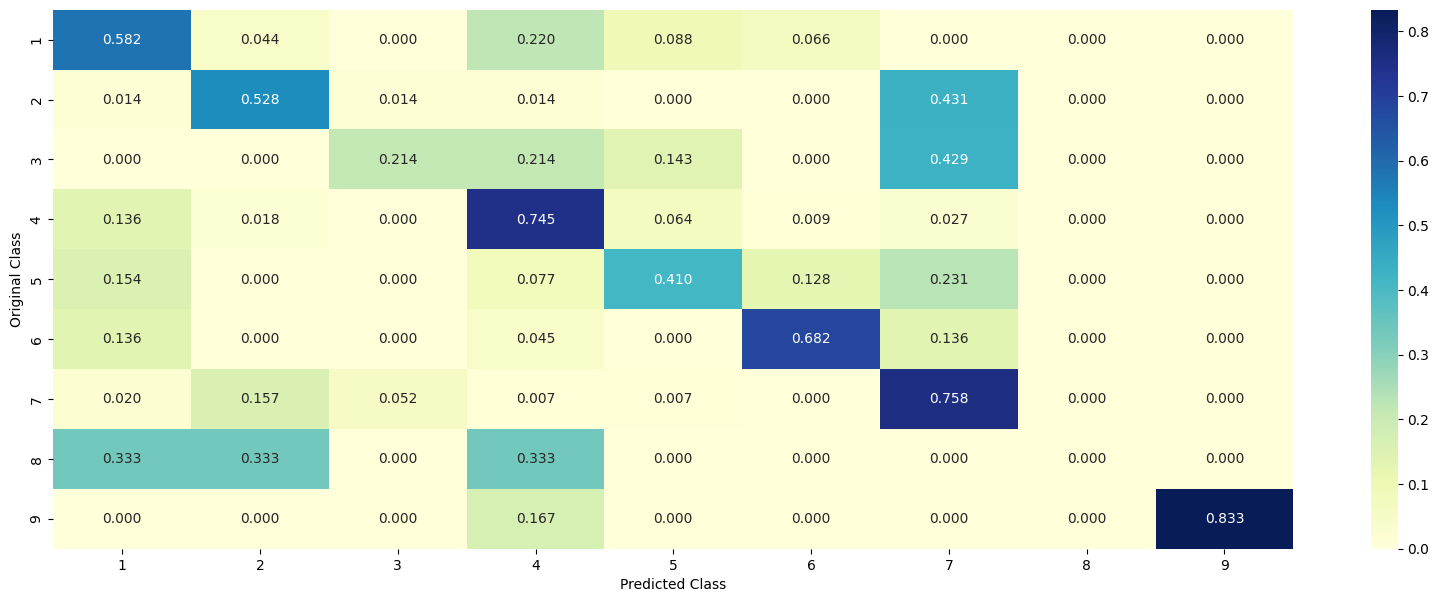

In [195]:

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>Sample Query point -1</h3>

In [196]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 5
The  11  nearest neighbours of the test points belongs to classes [6 7 2 7 2 7 6 2 7 7 2]
Fequency of nearest points : Counter({np.int64(7): 5, np.int64(2): 4, np.int64(6): 2})


<h3> Sample Query Point-2 </h3>

In [197]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 2 2 2 2]
Fequency of nearest points : Counter({np.int64(2): 11})


<h2>Logistic Regression</h2>

<h3>With Class balancing</h3>

<h4> Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.322241860525225
for alpha = 1e-05
Log Loss : 1.289943638299698
for alpha = 0.0001
Log Loss : 1.1171571779080534
for alpha = 0.001
Log Loss : 1.1091201135215656
for alpha = 0.01
Log Loss : 1.1848367772479413
for alpha = 0.1
Log Loss : 1.458959143579623
for alpha = 1
Log Loss : 1.6679128498884086
for alpha = 10
Log Loss : 1.6976532180634054
for alpha = 100
Log Loss : 1.700962133345761


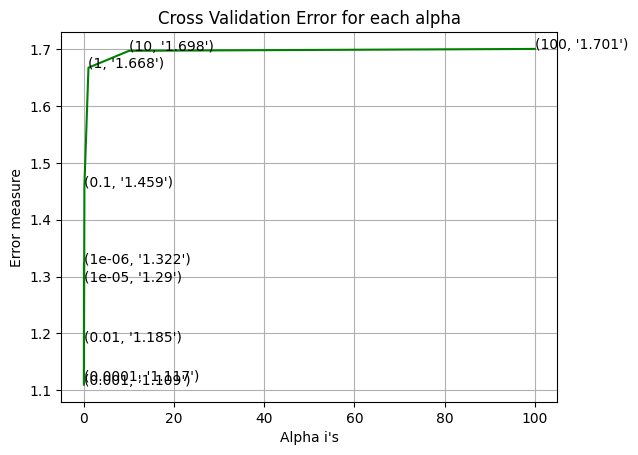

For values of best alpha = 0.001 The train log loss is: 0.5252138937314772
For values of best alpha = 0.001 The cross validation log loss is: 1.1091201135215656
For values of best alpha = 0.001 The test log loss is: 1.0963707079242144


In [198]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))


<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.1091201135215656
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


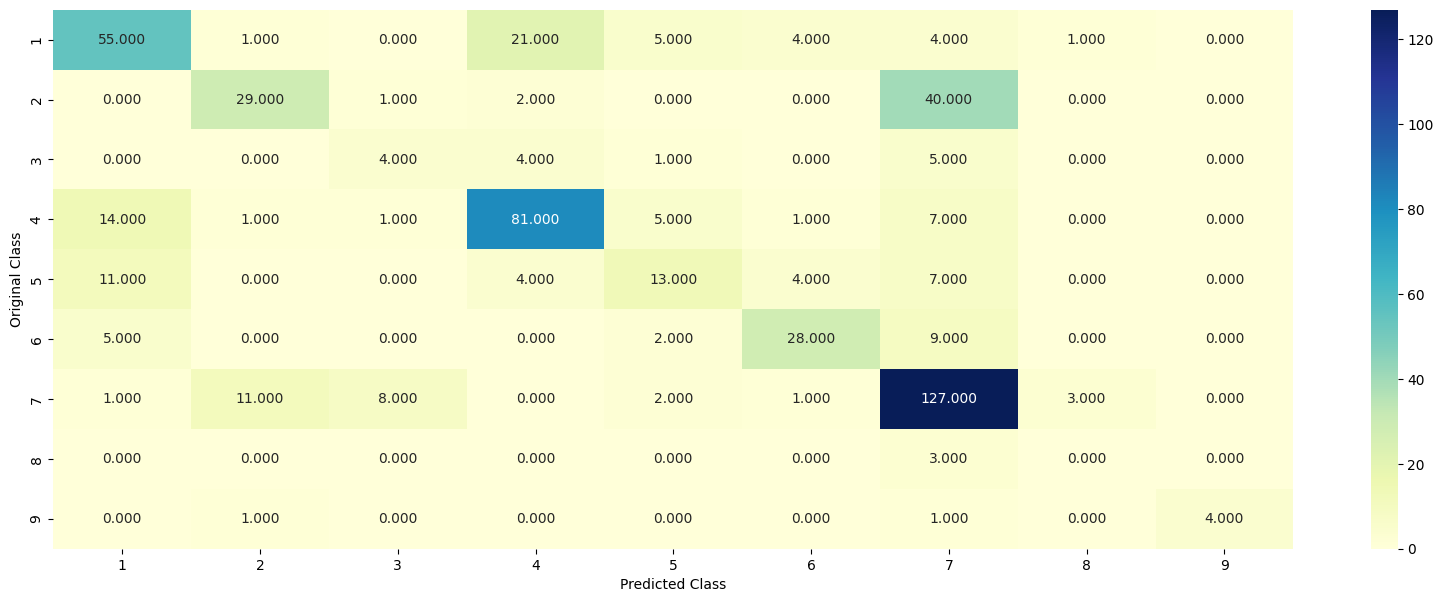

-------------------- Precision matrix (Columm Sum=1) --------------------


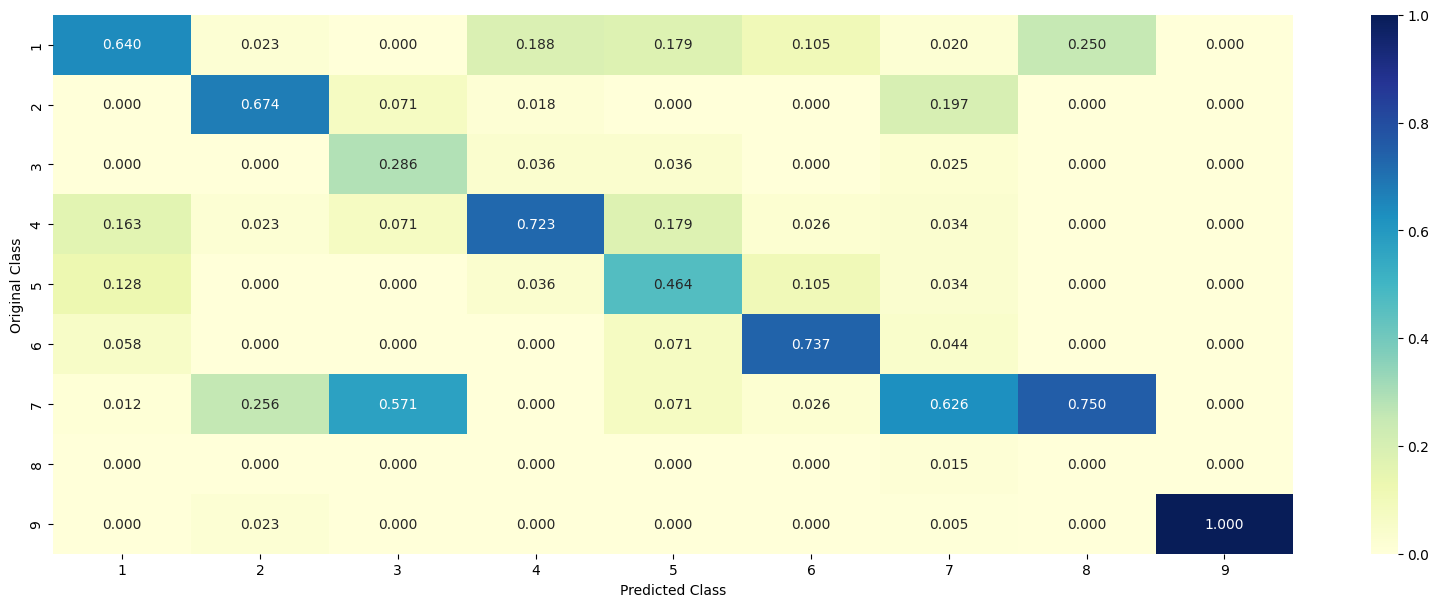

-------------------- Recall matrix (Row sum=1) --------------------


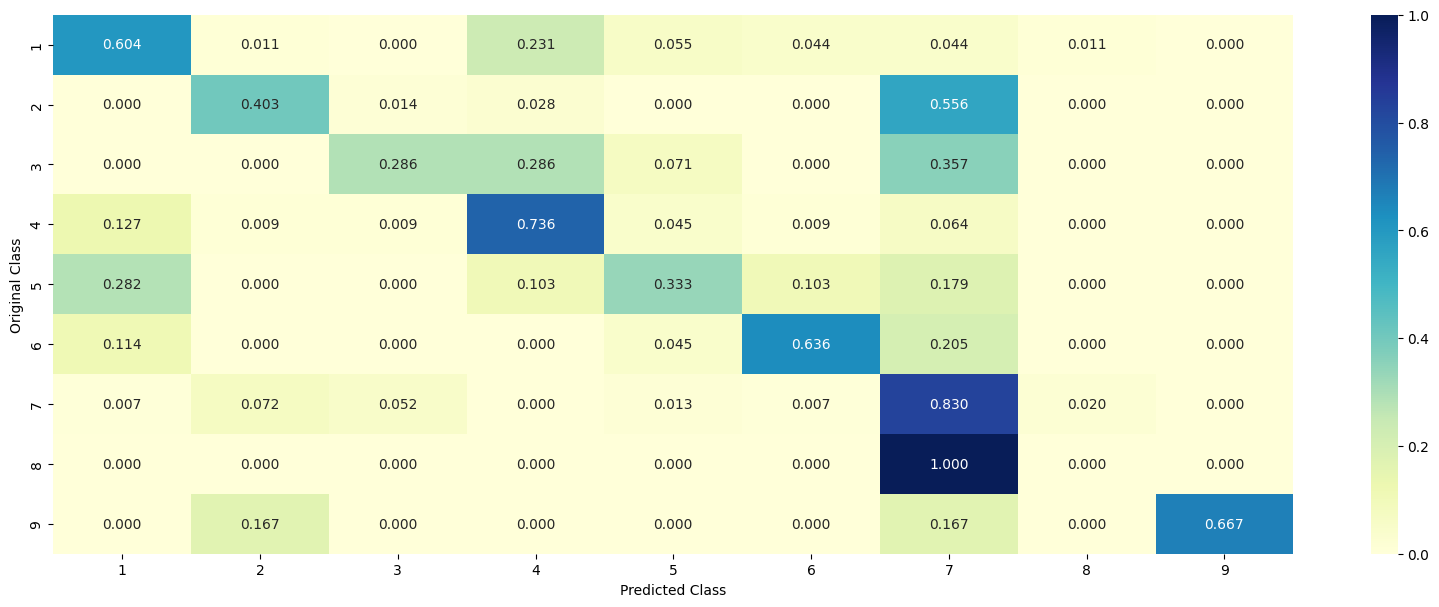

In [199]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


<h4>Feature Importance</h4>

In [200]:
from tabulate import tabulate

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)


clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index].reshape(1, -1)), 4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.coef_[int(predicted_cls[0]) - 1])[:no_feature]
print("-" * 50)

get_imp_feature_names(
    test_df['TEXT'].iloc[test_point_index],
    indices,
    removed_ind=[]
)

def get_imp_feature_names(text, indices, removed_ind=[]):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    gene_feat_len = train_gene_feature_onehotCoding.shape[1]
    var_feat_len = 18 - gene_feat_len  # Assuming variation ends at index 17

    for i in indices:
        if i < gene_feat_len:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i < 18:
            tabulte_list.append([incresingorder_ind, "Variation", "Yes"])
        elif (i not in removed_ind):
            text_feat_index = i - 18  # offset for text feature index
            if text_feat_index >= len(train_text_features):
                continue  # prevent index error
            word = train_text_features[text_feat_index]
            yes_no = word in text.split()
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind, word, yes_no])
        incresingorder_ind += 1

    print("most important features are present in our query point")
    print("-" * 50)
    print("The features that are most important for the", predicted_cls[0], "class:")
    print(tabulate(tabulte_list, headers=["Index", 'Feature name', 'Present or Not']))


Predicted Class : 6
Predicted Class Probabilities: [[0.0628 0.1355 0.0122 0.0711 0.0374 0.4885 0.1809 0.0057 0.0059]]
Actual Class : 5
--------------------------------------------------
most important features are present in our query point
--------------------------------------------------
The features that are most important for the 6 class:
  Index  Feature name           Present or Not
-------  ---------------------  ----------------
      0  Gene                   Yes
      1  Gene                   Yes
      2  080                    False
      3  11v559d                False
      4  Gene                   Yes
      5  200521                 False
      6  0299                   False
      7  1xkk                   False
      8  1953                   False
      9  1rjb                   False
     10  123456                 False
     11  1780g                  False
     12  191c                   False
     13  1886                   False
     14  1222                   

<h5> Correctly Classified point</h5>

In [201]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index].reshape(1, -1)), 4))
print("Actual Class :", test_y[test_point_index])

# Get top important feature indices for the predicted class
indices = np.argsort(-clf.coef_[int(predicted_cls[0]) - 1])[:no_feature]
print("-" * 50)

get_imp_feature_names(
    test_df['TEXT'].iloc[test_point_index],
    indices,
    removed_ind=[]
)


Predicted Class : 6
Predicted Class Probabilities: [[0.0628 0.1355 0.0122 0.0711 0.0374 0.4885 0.1809 0.0057 0.0059]]
Actual Class : 5
--------------------------------------------------
most important features are present in our query point
--------------------------------------------------
The features that are most important for the 6 class:
  Index  Feature name           Present or Not
-------  ---------------------  ----------------
      0  Gene                   Yes
      1  Gene                   Yes
      2  080                    False
      3  11v559d                False
      4  Gene                   Yes
      5  200521                 False
      6  0299                   False
      7  1xkk                   False
      8  1953                   False
      9  1rjb                   False
     10  123456                 False
     11  1780g                  False
     12  191c                   False
     13  1886                   False
     14  1222                   

In [202]:
test_point_index = 100
no_feature = 500

# Predict for single test point (reshape required)
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1, -1))
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:",
      np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index].reshape(1, -1)), 4))
print("Actual Class:", test_y[test_point_index])

# Correctly extract top feature indices
class_index = int(predicted_cls[0]) - 1
indices = np.argsort(-clf.coef_[class_index])[:no_feature]
print("-" * 50)

# Call your feature explanation function
get_imp_feature_names(
    test_df['TEXT'].iloc[test_point_index],
    indices,
    removed_ind=[]
)


Predicted Class: 2
Predicted Class Probabilities: [[0.106  0.3164 0.0272 0.0951 0.0501 0.1114 0.2792 0.0056 0.0089]]
Actual Class: 2
--------------------------------------------------
most important features are present in our query point
--------------------------------------------------
The features that are most important for the 2 class:
  Index  Feature name                    Present or Not
-------  ------------------------------  ----------------
      0  114                             False
      1  Gene                            Yes
      2  Gene                            Yes
      3  Gene                            Yes
      4  Gene                            Yes
      5  Gene                            Yes
      6  164757                          False
      7  0299                            False
      8  1303                            False
      9  2016cancer                      False
     10  Gene                            Yes
     11  Gene                        

<h3>Without Class balancing</h3>

<h4>Hyper paramter tuning</h4>

For alpha = 1e-06
Log Loss: 1.2893107807775062
For alpha = 1e-05
Log Loss: 1.2788993424947543
For alpha = 0.0001
Log Loss: 1.1223994822840218
For alpha = 0.001
Log Loss: 1.1083894966855632
For alpha = 0.01
Log Loss: 1.1953225428282914
For alpha = 0.1
Log Loss: 1.3987482234840414
For alpha = 1
Log Loss: 1.609118453259491


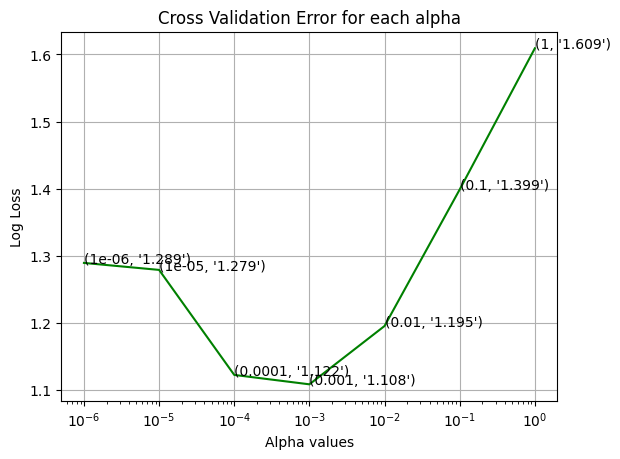

For best alpha = 0.001 Train log loss: 0.5187227994932202
For best alpha = 0.001 CV log loss: 1.1083894966855632
For best alpha = 0.001 Test log loss: 1.1042570205236835


In [203]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    logloss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(logloss)
    print("Log Loss:", logloss)

# Plotting
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.xscale('log')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.show()

# Best alpha
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For best alpha =', best_alpha, "Train log loss:", log_loss(train_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For best alpha =', best_alpha, "CV log loss:", log_loss(cv_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For best alpha =', best_alpha, "Test log loss:", log_loss(test_y, predict_y, labels=clf.classes_))


<h4> Testing model with best hyper parameters</h4>

Log loss : 1.1083894966855632
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


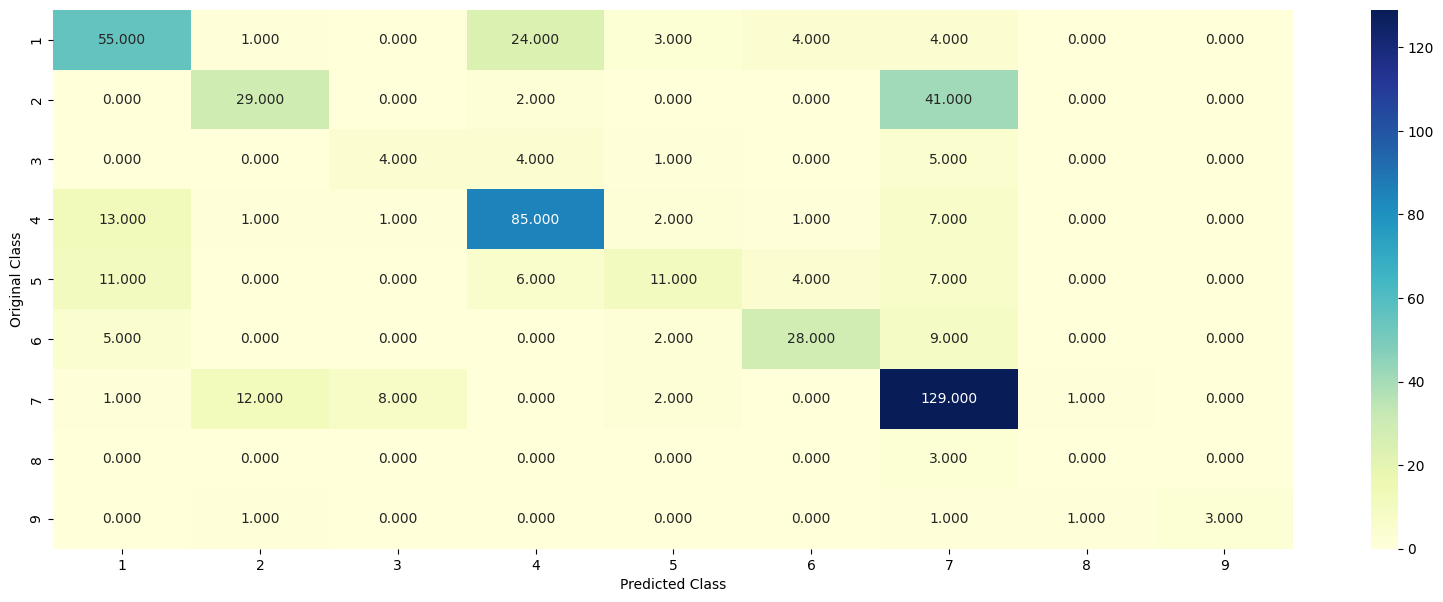

-------------------- Precision matrix (Columm Sum=1) --------------------


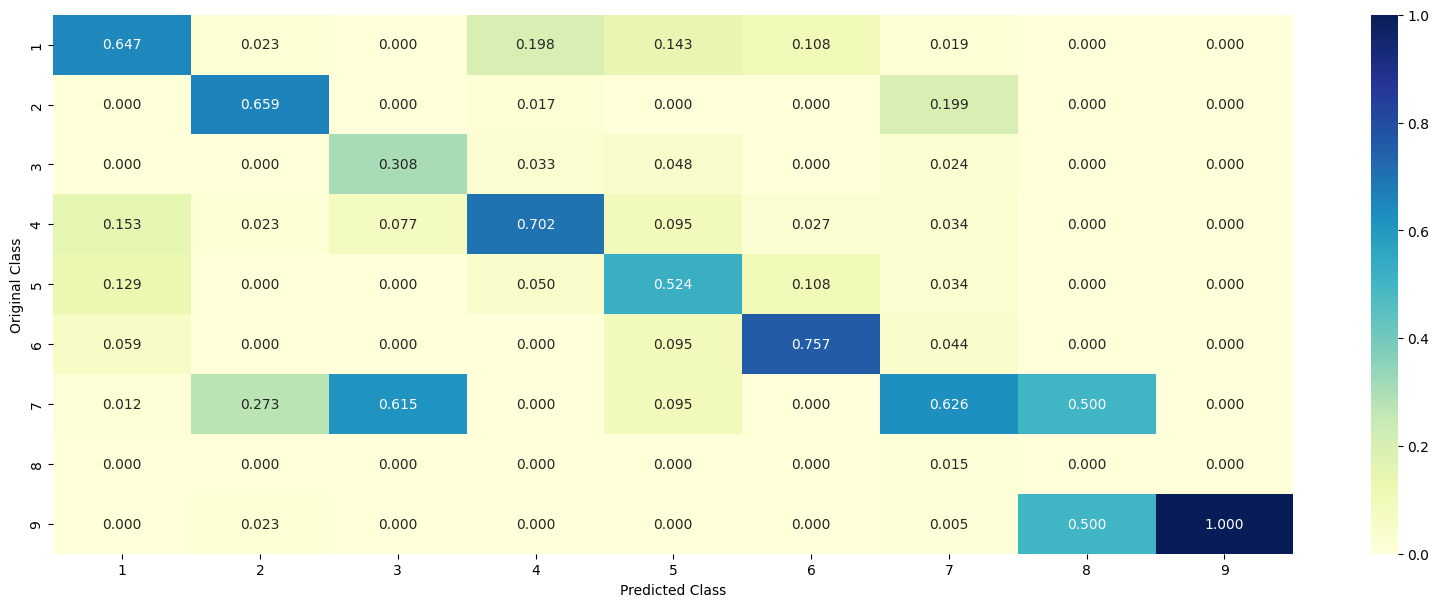

-------------------- Recall matrix (Row sum=1) --------------------


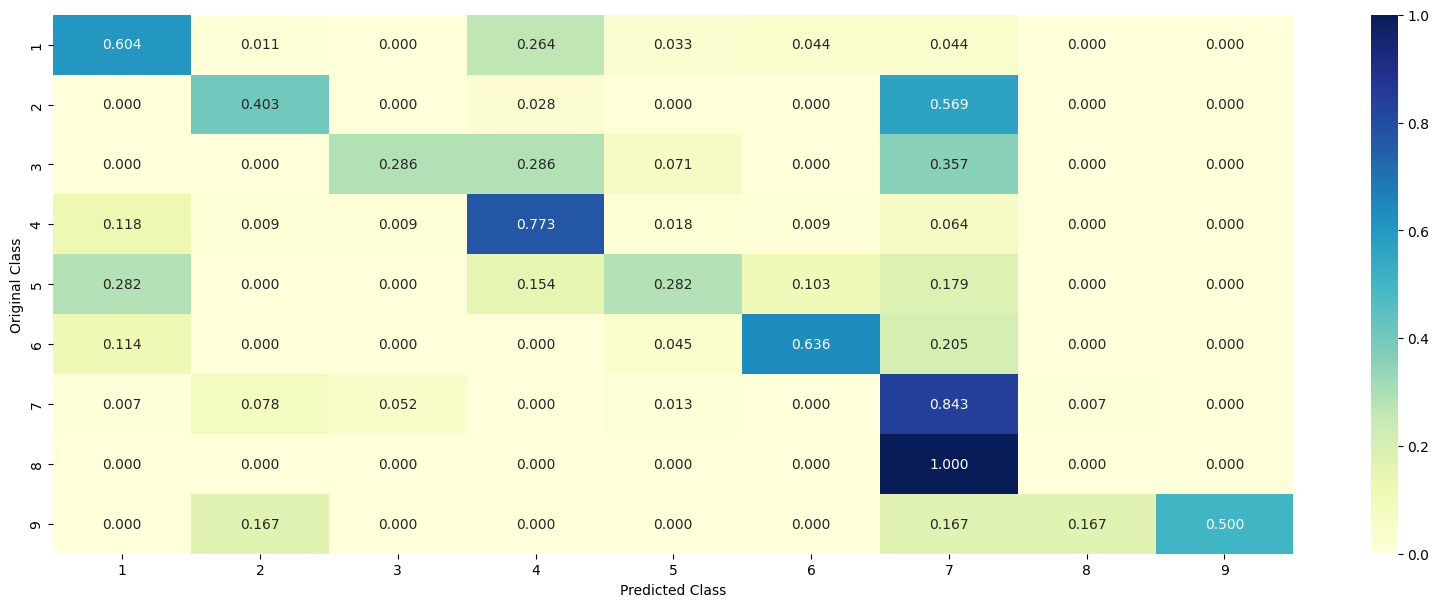

In [204]:
best_alpha = alpha[best_alpha_index]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,
                                  cv_x_onehotCoding, cv_y, clf)


<h4>Feature Importance, Correctly Classified point</h4>

In [205]:
clf = SGDClassifier(alpha=alpha[int(best_alpha)], penalty='l2', loss='log_loss', random_state=42)

clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 500

# Make sure to reshape input when predicting a single point
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])

print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index].reshape(1, -1)), 4))
print("Actual Class :", test_y[test_point_index])

# Get indices of top features for the predicted class
indices = np.argsort(-clf.coef_[predicted_cls[0] - 1])[:no_feature]
print("-" * 50)

get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index],
                     no_feature)


Predicted Class : 6
Predicted Class Probabilities: [[0.0638 0.1395 0.0155 0.0701 0.0408 0.4962 0.1616 0.0063 0.0062]]
Actual Class : 5
--------------------------------------------------
122 Text feature [pgem] present in test data point [True]
440 Text feature [p261a] present in test data point [True]
470 Text feature [blastomeres] present in test data point [True]
472 Text feature [pericardium] present in test data point [True]
490 Text feature [otoliths] present in test data point [True]
Out of the top 500 features, 5 are present in the query point


<h2>Linear Support Vector Machines</h2>

<h3> Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2925535404933042
for C = 0.0001
Log Loss : 1.1933903317162915
for C = 0.001
Log Loss : 1.138252226566949
for C = 0.01
Log Loss : 1.153413755696613
for C = 0.1
Log Loss : 1.3807707717481736
for C = 1
Log Loss : 1.6846233177994563
for C = 10
Log Loss : 1.701539199015395
for C = 100
Log Loss : 1.7015406151305195


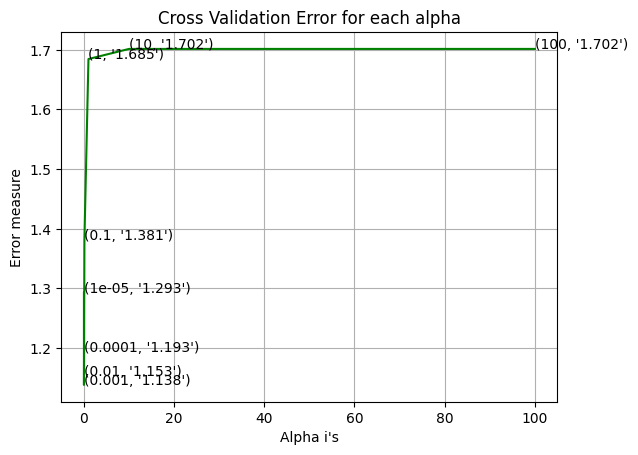

For values of best alpha =  0.001 The train log loss is: 0.5392344913857576
For values of best alpha =  0.001 The cross validation log loss is: 1.138252226566949
For values of best alpha =  0.001 The test log loss is: 1.1391959279214359


In [206]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.138252226566949
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


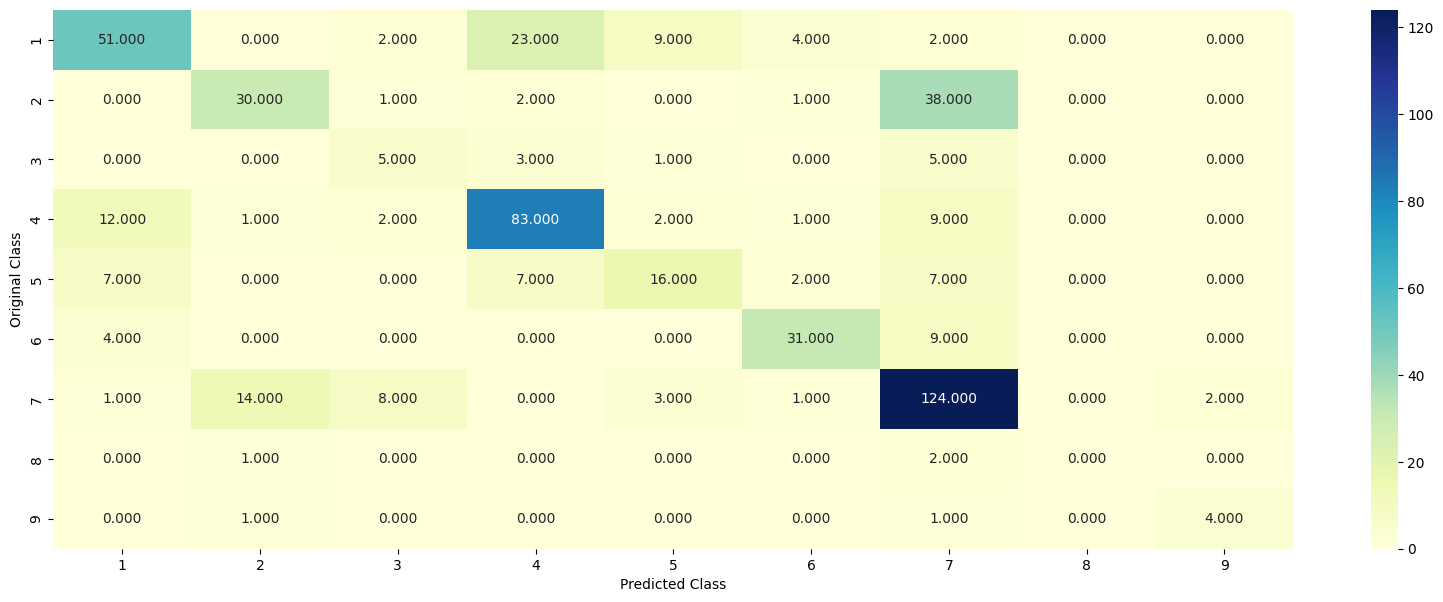

-------------------- Precision matrix (Columm Sum=1) --------------------


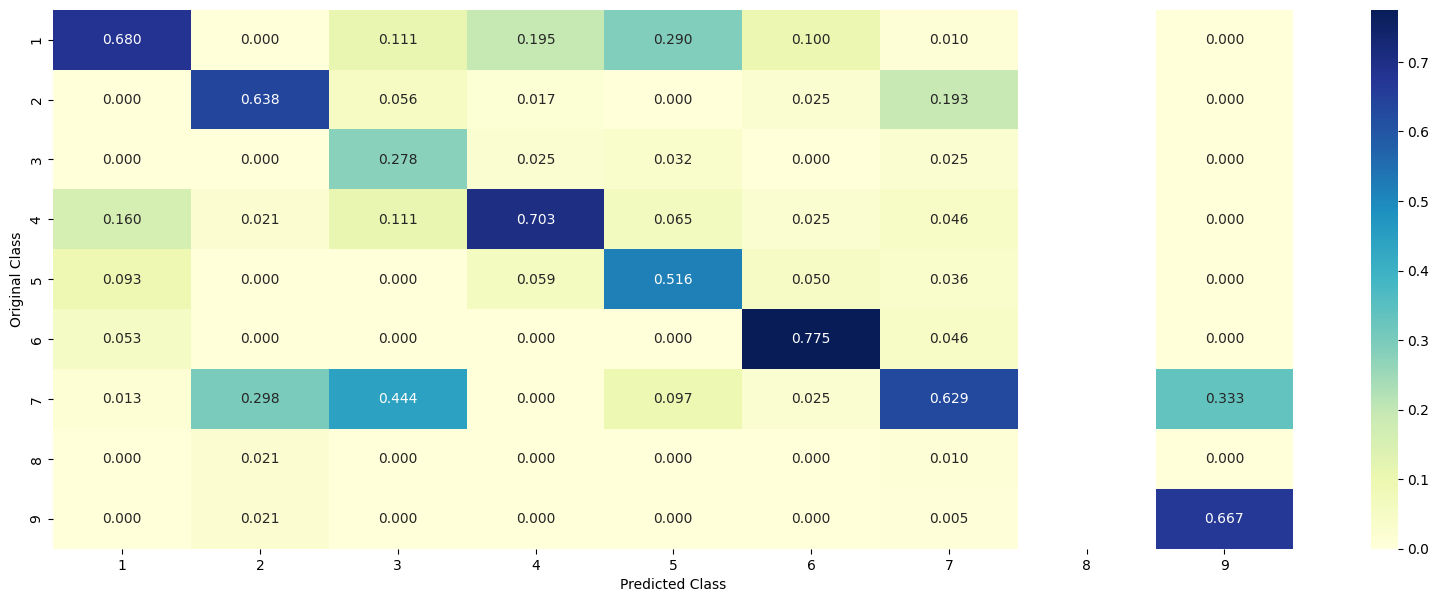

-------------------- Recall matrix (Row sum=1) --------------------


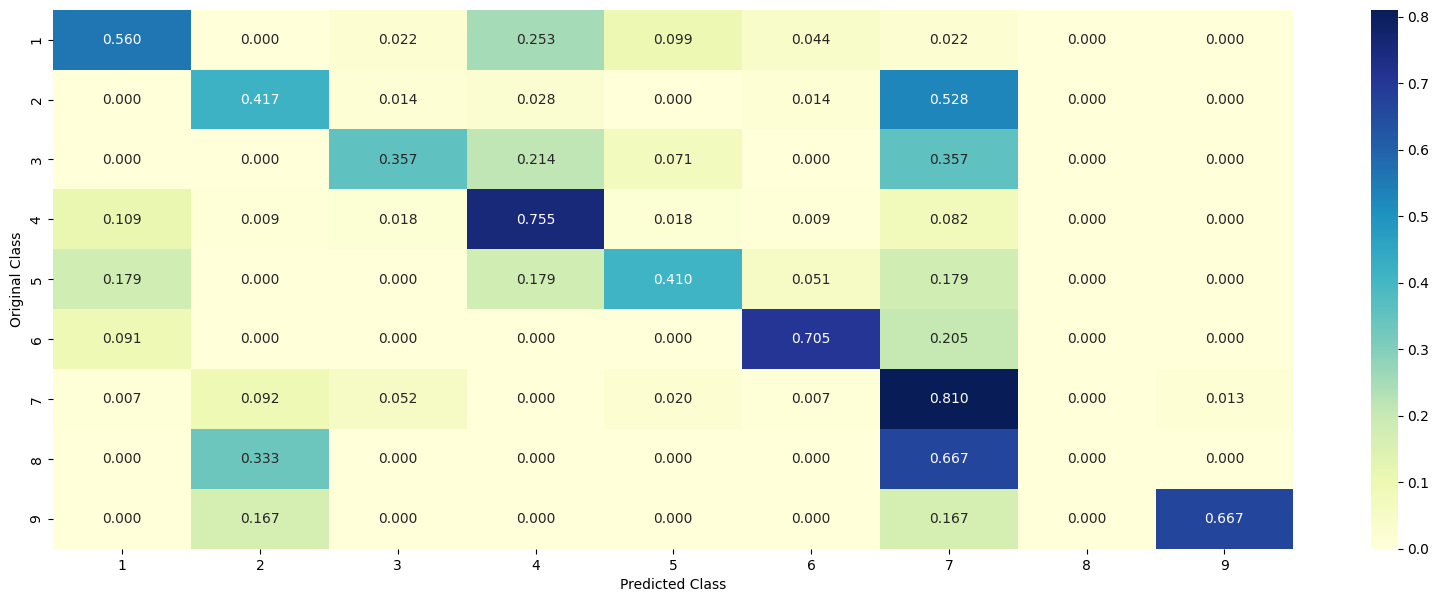

In [207]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>Feature Importance</h3>

In [208]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0673 0.0979 0.0137 0.0703 0.0372 0.5689 0.1343 0.0053 0.0052]]
Actual Class : 5
--------------------------------------------------
112 Text feature [p261a] present in test data point [True]
120 Text feature [otoliths] present in test data point [True]
122 Text feature [pgem] present in test data point [True]
123 Text feature [blastomeres] present in test data point [True]
135 Text feature [s257l] present in test data point [True]
144 Text feature [morpholino] present in test data point [True]
164 Text feature [cr2] present in test data point [True]
165 Text feature [anteriorly] present in test data point [True]
196 Text feature [pericardium] present in test data point [True]
228 Text feature [maternally] present in test data point [True]
230 Text feature [e501k] present in test data point [True]
243 Text feature [microinjections] present in test data point [True]
257 Text feature [tube] present in test data point [True]
293 Text fe

In [209]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1477 0.2452 0.0303 0.116  0.0571 0.2307 0.1583 0.007  0.0077]]
Actual Class : 2
--------------------------------------------------
Out of the top 500 features, 0 are present in the query point


<h2> Random Forest Classifier</h2>

<h3>Hyper paramter tuning (With One hot Encoding)</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.2441348352246682
for n_estimators = 100 and max depth =  10
Log Loss : 1.160887529138159
for n_estimators = 200 and max depth =  5
Log Loss : 1.2343557797091285
for n_estimators = 200 and max depth =  10
Log Loss : 1.1537783998884346
for n_estimators = 500 and max depth =  5
Log Loss : 1.2314691450408441
for n_estimators = 500 and max depth =  10
Log Loss : 1.1485522543832019
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2258953386234943
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1490528738341852
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2239401733039796
for n_estimators = 2000 and max depth =  10
Log Loss : 1.148531338167963


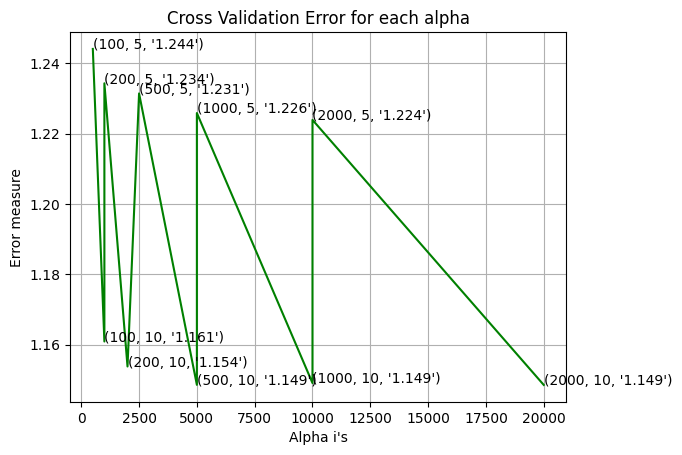

For values of best estimator =  2000 The train log loss is: 0.6885990896003417
For values of best estimator =  2000 The cross validation log loss is: 1.148531338167963
For values of best estimator =  2000 The test log loss is: 1.1482383353210175


In [210]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.148531338167963
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


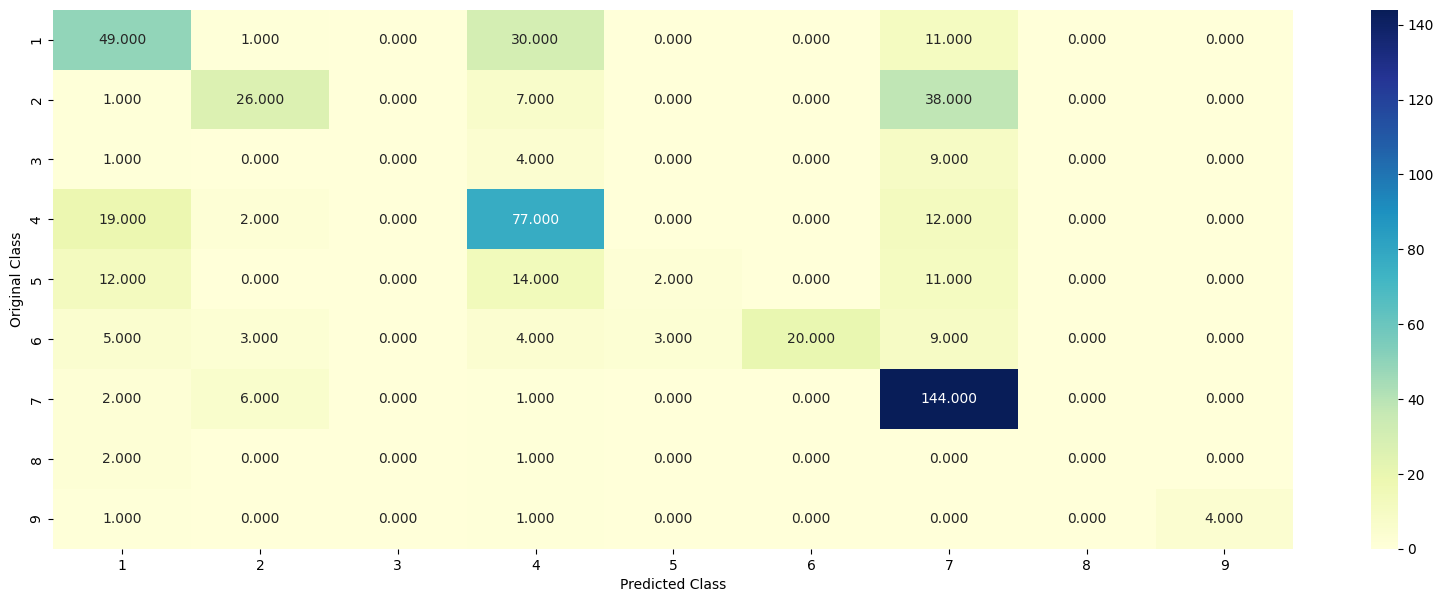

-------------------- Precision matrix (Columm Sum=1) --------------------


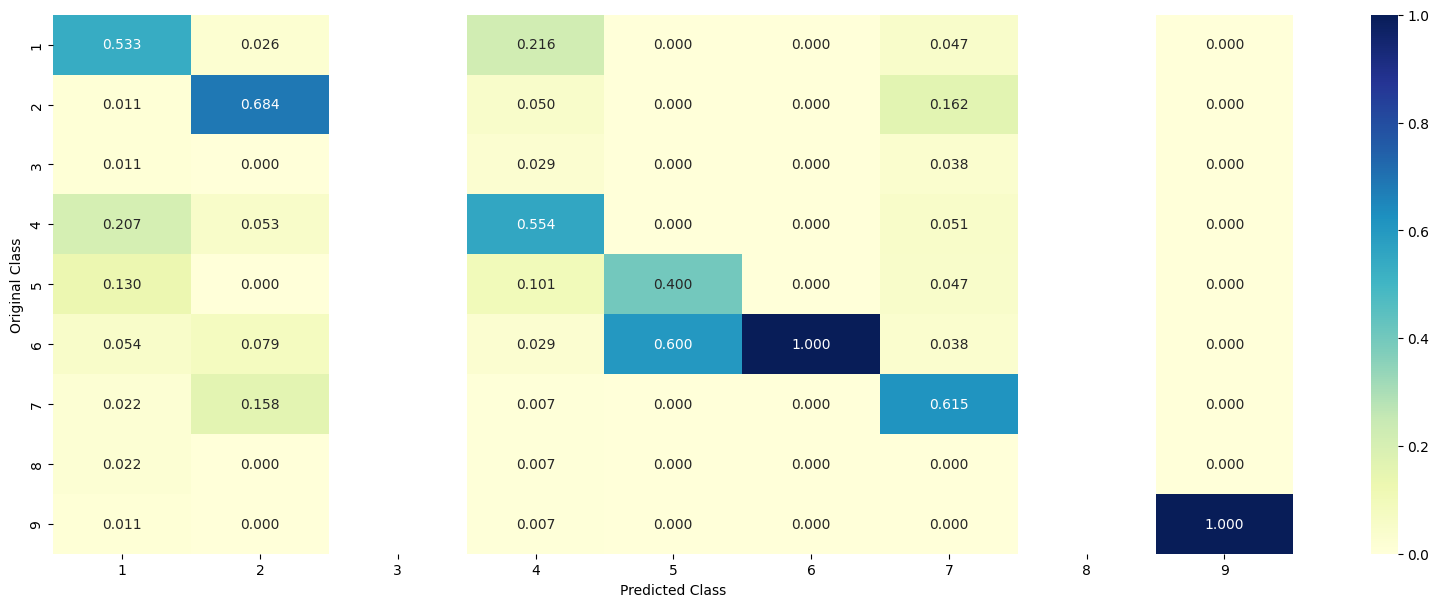

-------------------- Recall matrix (Row sum=1) --------------------


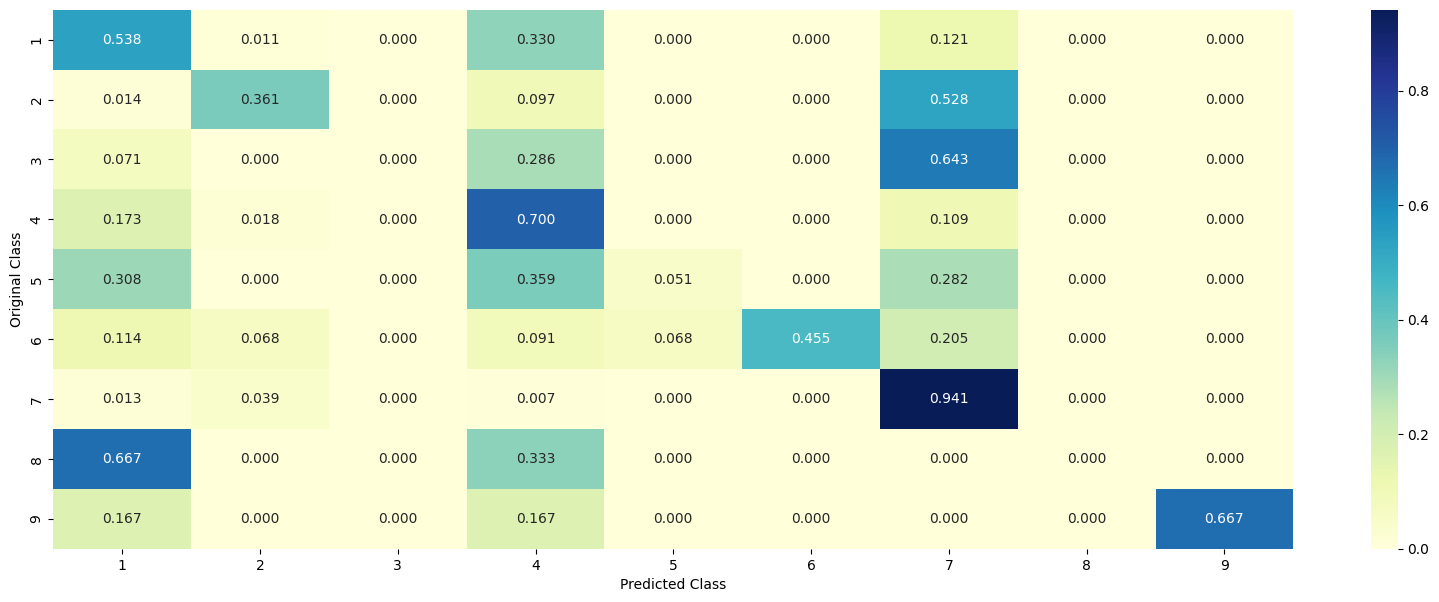

In [211]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>Feature Importance</h3>

In [212]:

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.103  0.1454 0.0241 0.1282 0.0593 0.0664 0.4575 0.0086 0.0075]]
Actual Class : 5
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
4 Text feature [activation] present in test data point [True]
6 Text feature [activated] present in test data point [True]
7 Text feature [function] present in test data point [True]
8 Text feature [constitutive] present in test data point [True]
9 Text feature [missense] present in test data point [True]
10 Text feature [signaling] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
15 Text feature [erk] present in test data point [True]
16 Text feature [treatment] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
23 Text feature

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [213]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0015538292558928
for n_estimators = 10 and max depth =  3
Log Loss : 1.625777321666013
for n_estimators = 10 and max depth =  5
Log Loss : 1.293877912847094
for n_estimators = 10 and max depth =  10
Log Loss : 1.9298009355050363
for n_estimators = 50 and max depth =  2
Log Loss : 1.651824896861932
for n_estimators = 50 and max depth =  3
Log Loss : 1.3961105069209587
for n_estimators = 50 and max depth =  5
Log Loss : 1.291508926551656
for n_estimators = 50 and max depth =  10
Log Loss : 1.7729494700285189
for n_estimators = 100 and max depth =  2
Log Loss : 1.5214726333357378
for n_estimators = 100 and max depth =  3
Log Loss : 1.432394803890057
for n_estimators = 100 and max depth =  5
Log Loss : 1.2803029791282923
for n_estimators = 100 and max depth =  10
Log Loss : 1.7527318784328458
for n_estimators = 200 and max depth =  2
Log Loss : 1.5573710248492802
for n_estimators = 200 and max depth =  3
Log Loss : 1.4227655549325617
fo

<h3> Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.2803029791282925
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


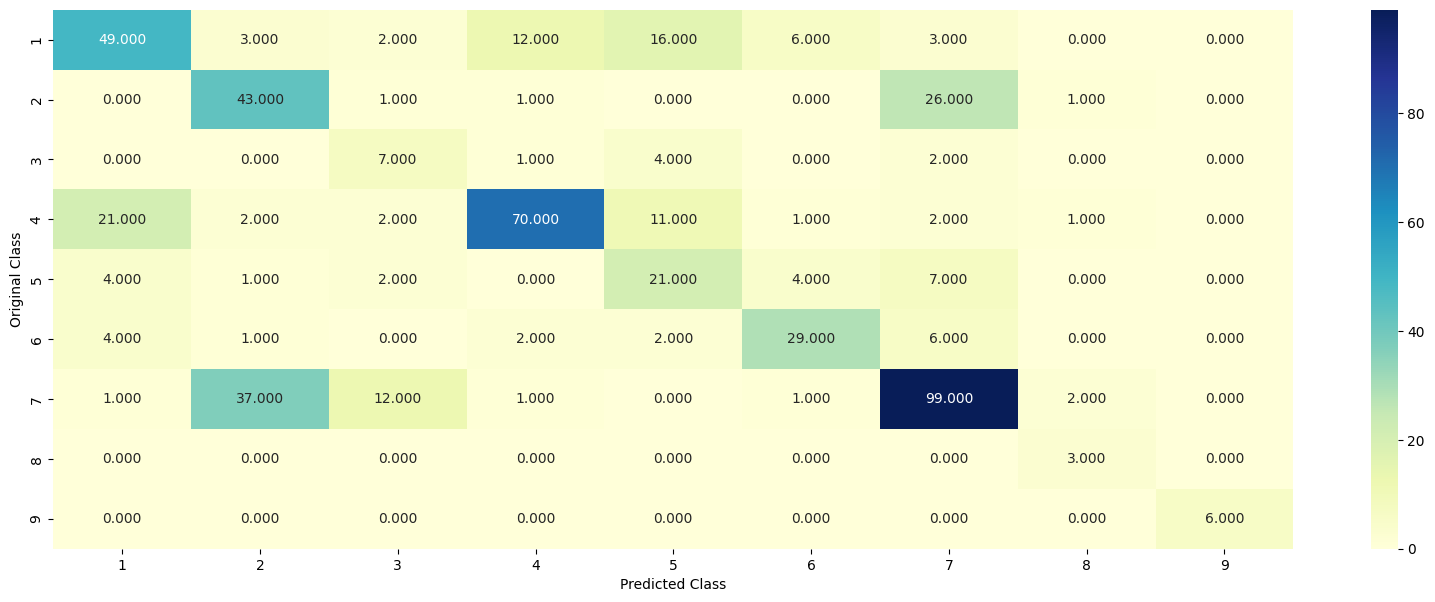

-------------------- Precision matrix (Columm Sum=1) --------------------


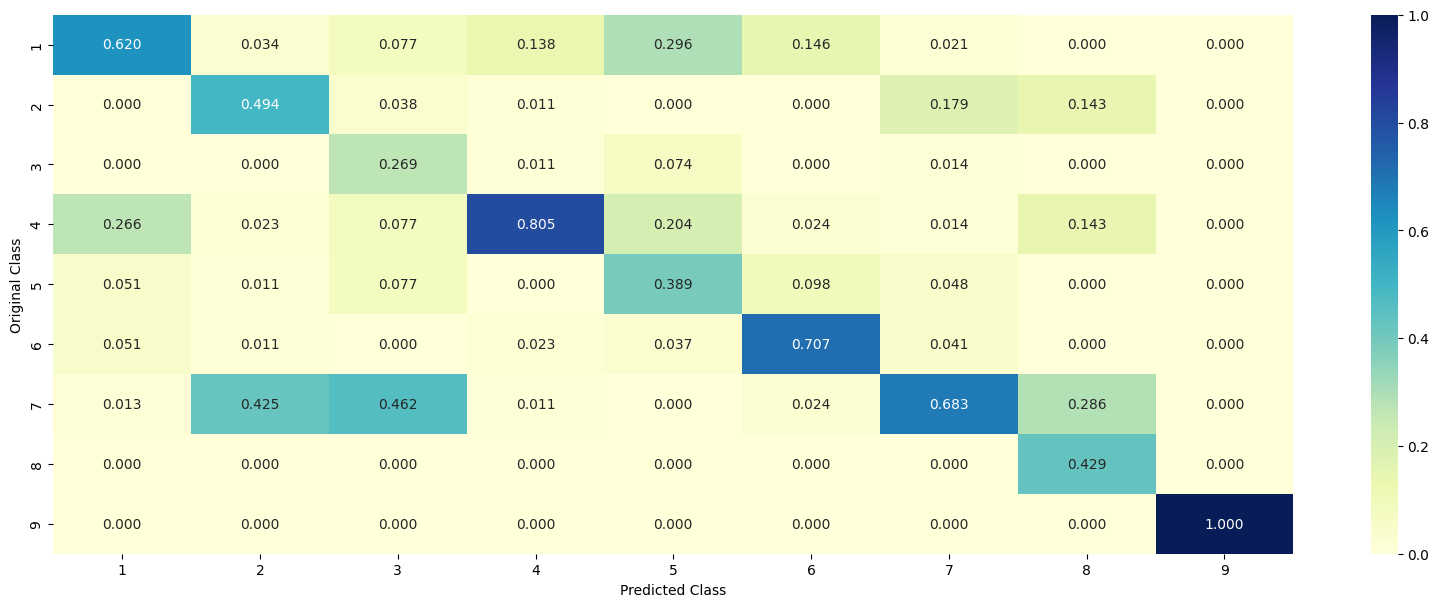

-------------------- Recall matrix (Row sum=1) --------------------


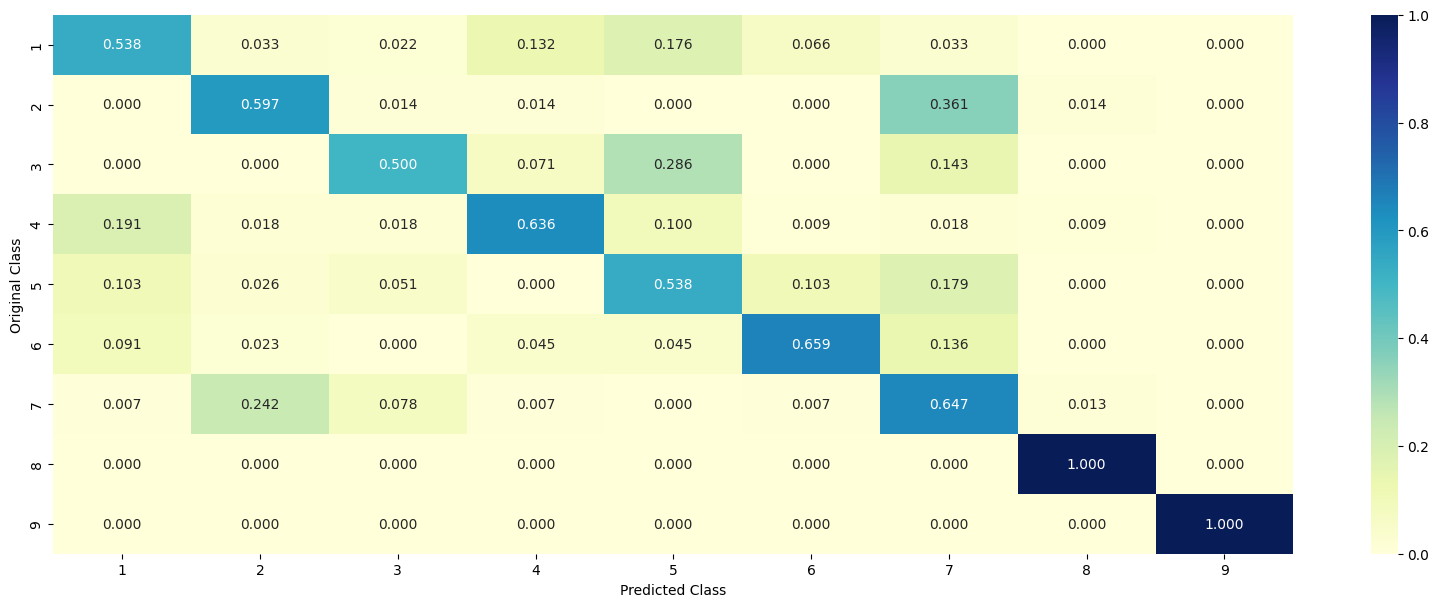

In [214]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='sqrt', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)


<h3> Feature Importance</h3>

In [215]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0211 0.293  0.1185 0.0356 0.0438 0.124  0.2986 0.0436 0.0217]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature


<h2>Stack the models </h2>

<h3> testing with hyper parameter tuning</h3>

In [216]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-" * 50)

alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))

    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.68
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.723
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.326
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.147
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.406
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.679


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.49142672371759927
Log loss (CV) on the stacking classifier : 1.1465382787954566
Log loss (test) on the stacking classifier : 1.1765988767383602
Number of missclassified point : 0.3593984962406015
-------------------- Confusion matrix --------------------


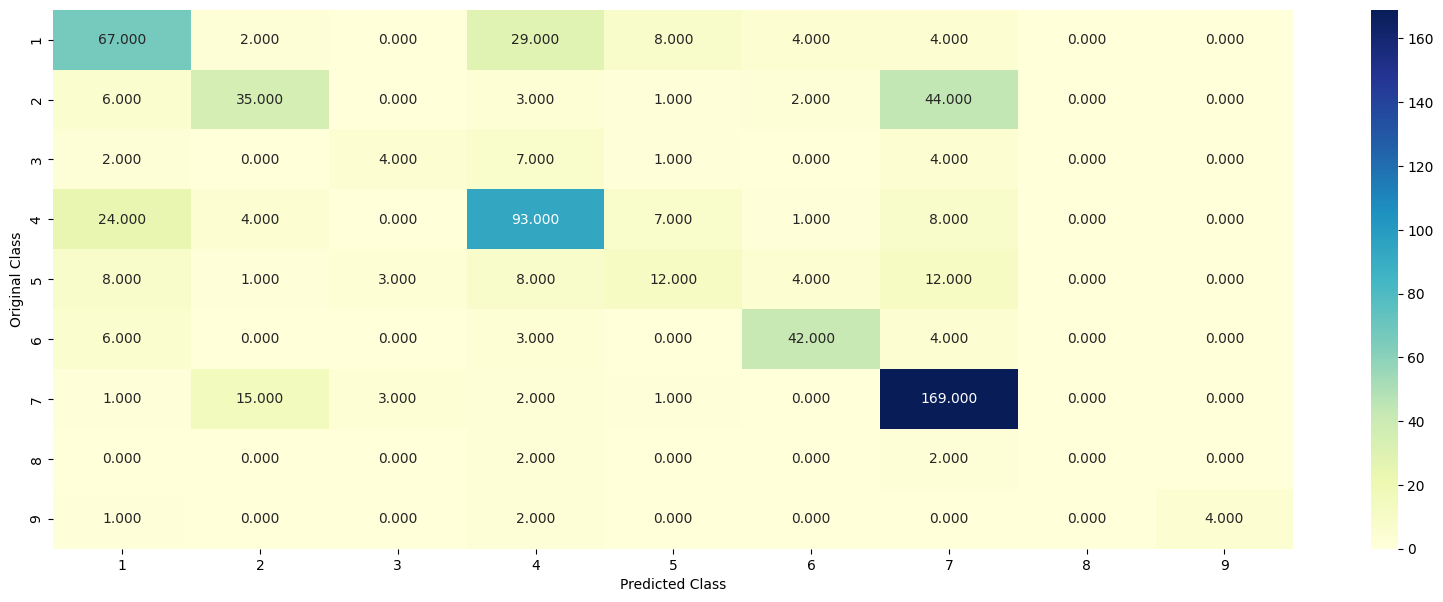

-------------------- Precision matrix (Columm Sum=1) --------------------


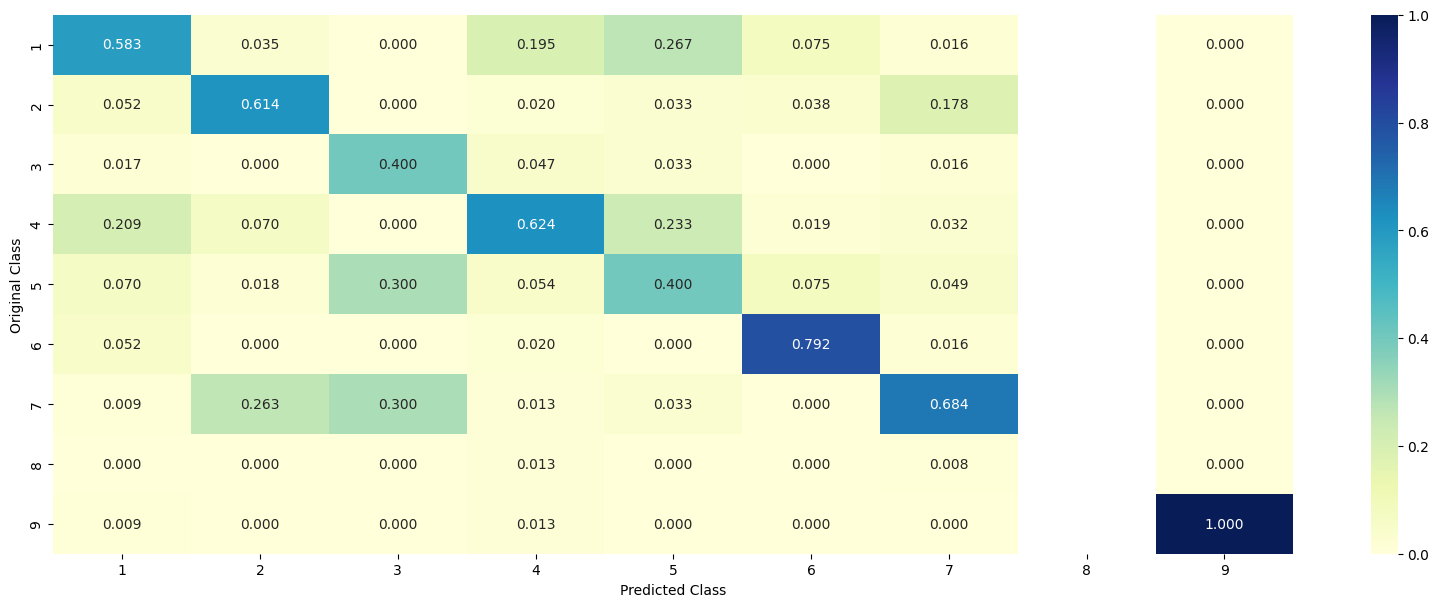

-------------------- Recall matrix (Row sum=1) --------------------


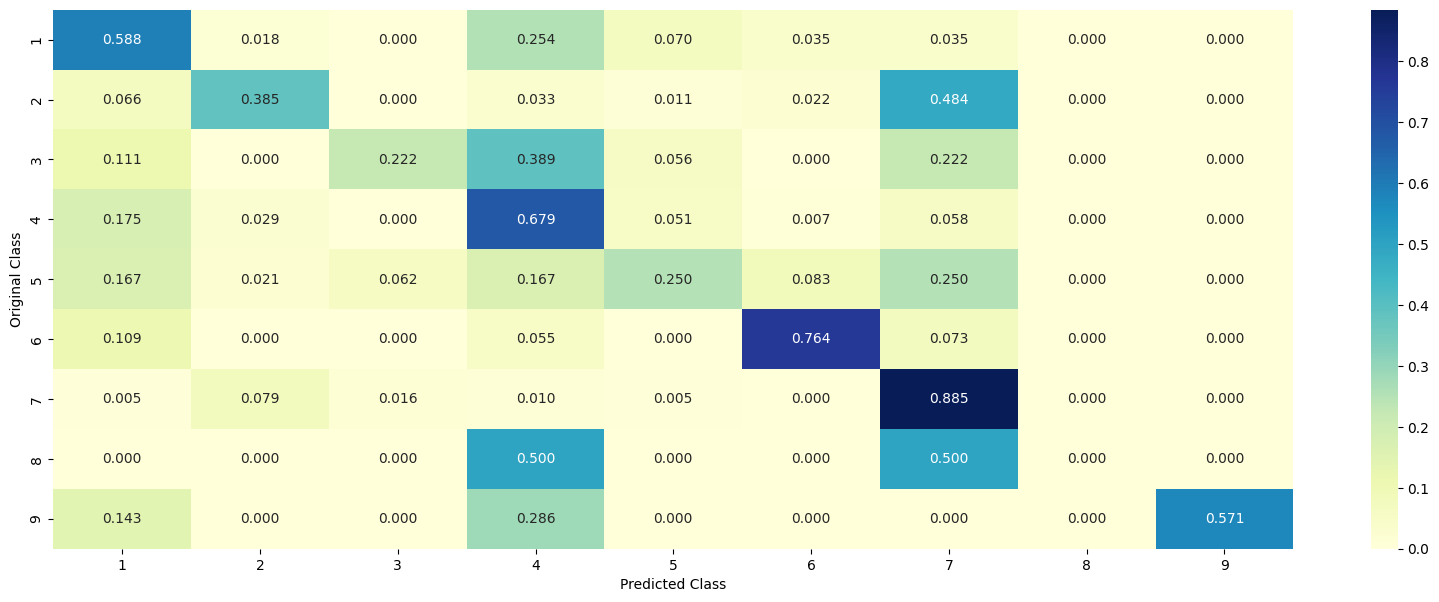

In [217]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8743689038138494
Log loss (CV) on the VotingClassifier : 1.177113526719062
Log loss (test) on the VotingClassifier : 1.2068055878250454
Number of missclassified point : 0.3699248120300752
-------------------- Confusion matrix --------------------


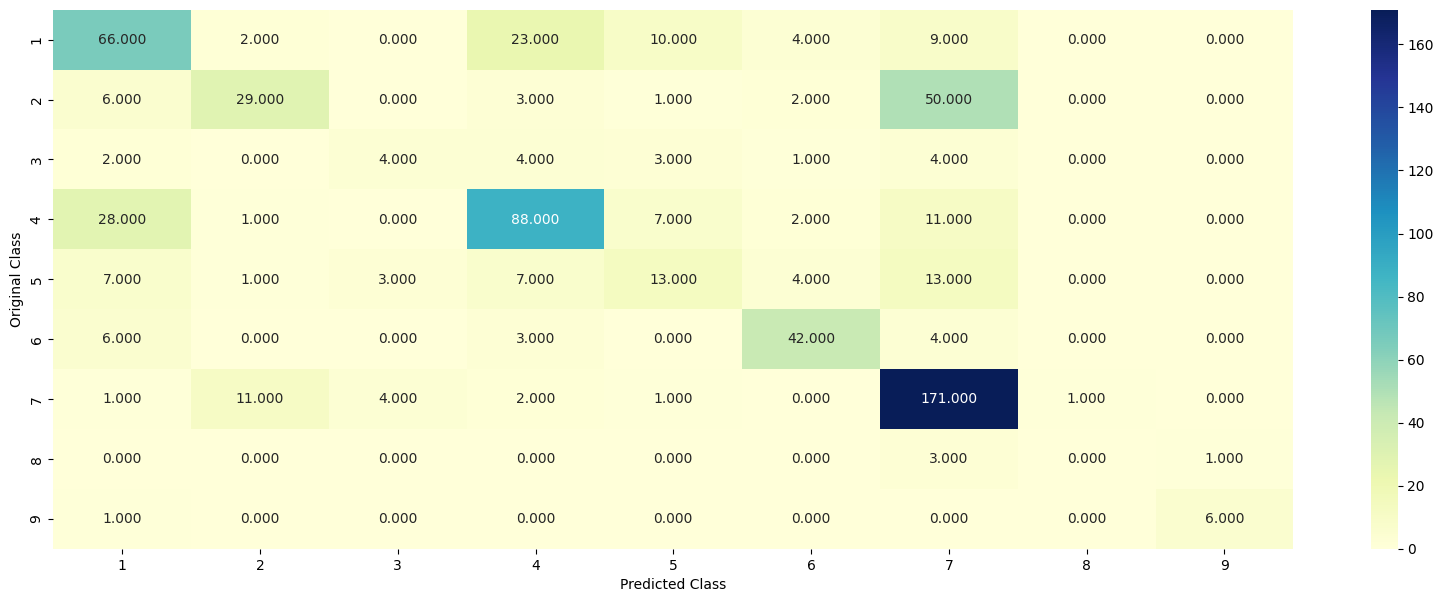

-------------------- Precision matrix (Columm Sum=1) --------------------


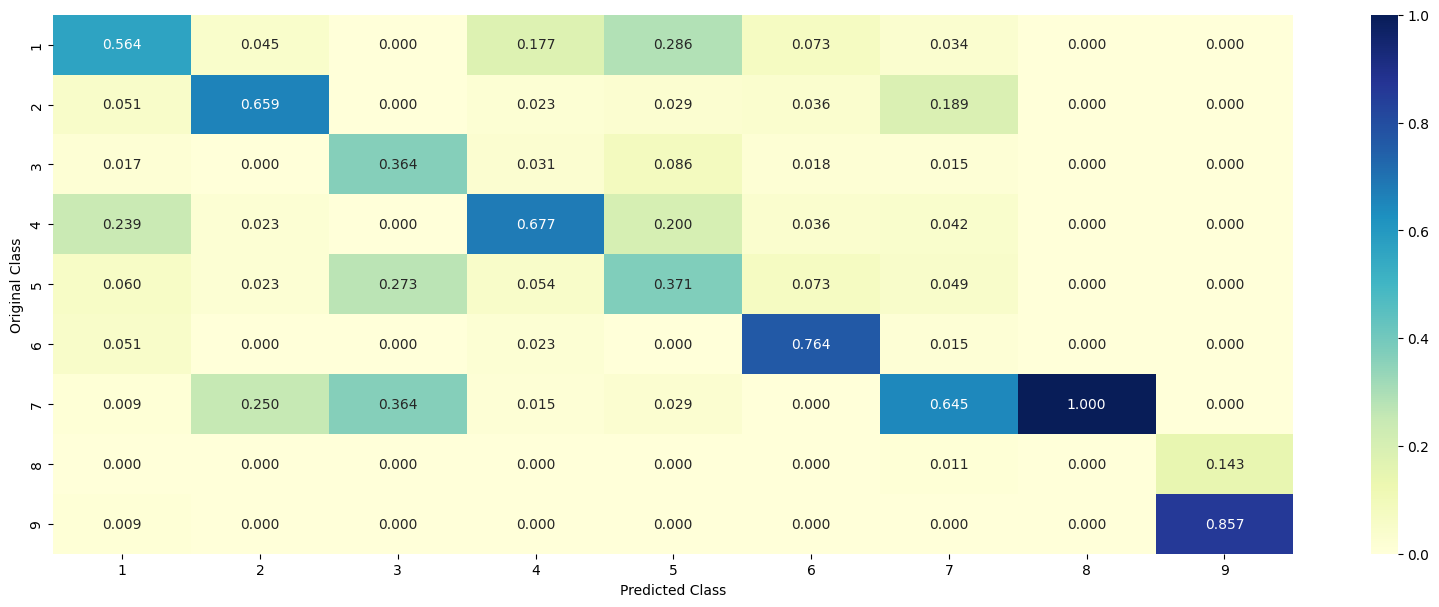

-------------------- Recall matrix (Row sum=1) --------------------


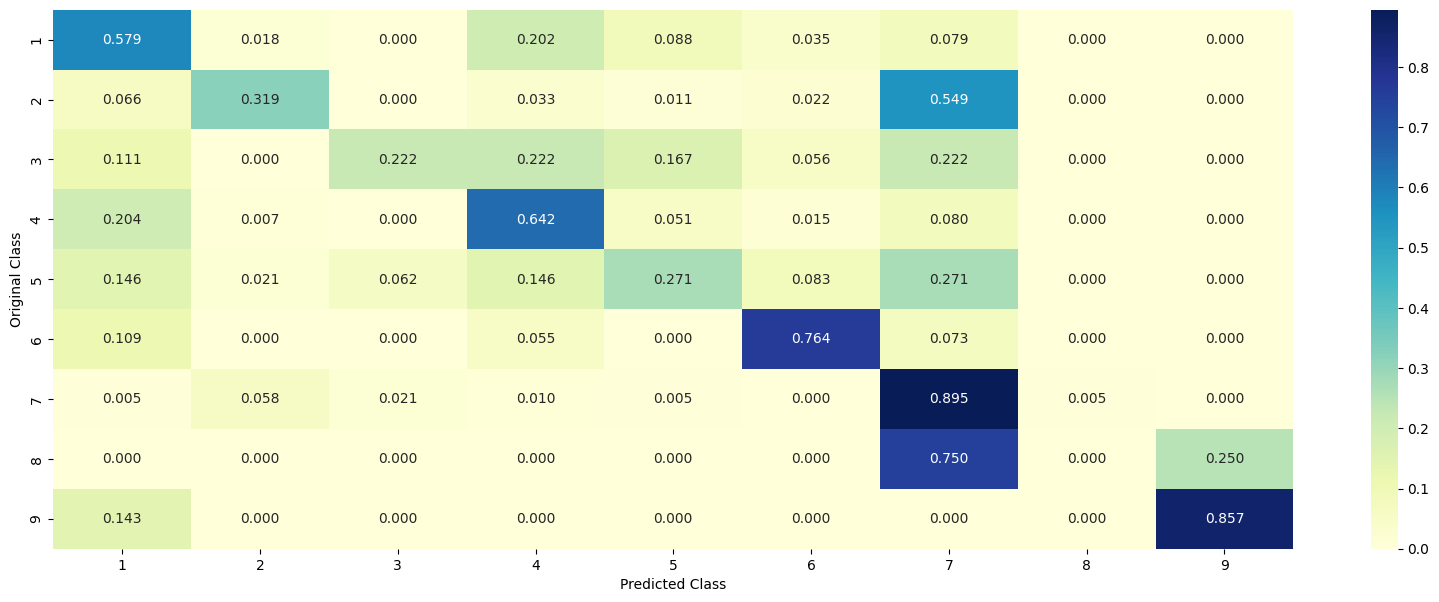

In [218]:

from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))